In [1]:
# !pip install statsmodels pingouin

# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import re

### Analysis of the trichomes vs cannabinoids

In [2]:
def clean_and_merge_datasets(trichome_path, cannabinoid_path):
    """
    Cleans and merges the trichome class distribution dataset with the cannabinoid levels dataset.
    """
    # Load the datasets
    trichome_df = pd.read_csv(trichome_path)
    cannabinoid_df = pd.read_excel(cannabinoid_path)

    # Clean column names in cannabinoid dataset
    cannabinoid_df.columns = cannabinoid_df.columns.str.strip().str.lower().str.replace(' ', '_')

    # Rename flower identifier column for consistency
    cannabinoid_df.rename(columns={'chromatogram\n_name': 'flower_id'}, inplace=True)

    # Ensure `day` in trichome dataset is in a consistent format (extract just the day number)
    trichome_df['day'] = trichome_df['day'].str.extract(r'day_(\d+)_\d{4}_\d{2}_\d{2}').astype(int)

    # Convert flower numbers to a common identifier
    trichome_df.rename(columns={'number': 'flower_id'}, inplace=True)

    # Convert flower_id to string for consistent merging
    trichome_df['flower_id'] = trichome_df['flower_id'].astype(str)
    cannabinoid_df['flower_id'] = cannabinoid_df['flower_id'].astype(str)

    # Extract numeric flower ID from the cannabinoid dataset (assuming format like 'XX-N')
    cannabinoid_df['flower_id'] = cannabinoid_df['flower_id'].apply(
        lambda x: re.search(r'(\d+)$', x).group(1) if re.search(r'(\d+)$', x) else x
    )

    # Merge datasets on flower_id and day
    merged_df = pd.merge(trichome_df, cannabinoid_df, on='flower_id', how='inner')

    return merged_df

# Run the function on the uploaded datasets
trichome_data_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/experiment_2/results/faster_rcnn_with_yolo/csv_results/collected_class_distribution_per_folder.csv"
cannabinoid_data_path = "/home/etaylor/code_projects/thesis/src/data_analysis/assessing_cannabis_maturity/experiment_2/cannabinoids_exp2_clean.xlsx"

merged_df = clean_and_merge_datasets(trichome_data_path, cannabinoid_data_path)
merged_df.head()


day    location flower_id  clear_count  cloudy_count  amber_count  \
0    1  greenhouse        15          209          1501           16   
1    1  greenhouse        14          305          1333            7   
2    1  greenhouse        13          141          2257           34   
3    1  greenhouse        12          273          1665            8   
4    1  greenhouse        11          380          1034           15   

   clear_normalized  cloudy_normalized  amber_normalized     var       rep  \
0            0.1211             0.8696            0.0093     616     616-8   
1            0.1854             0.8103            0.0043  1416-3  1416-3-7   
2            0.0580             0.9280            0.0140  805-12  805-12-6   
3            0.1403             0.8556            0.0041     616     616-6   
4            0.2659             0.7236            0.0105  1416-3  1416-3-5   

   total_cbd  total_thc  total_cbg    total_c  
0   0.271170  16.478827   1.155735  17.905733  
1   0.380153  15.803839   1.430155  17.614146  
2  13.402300   4.381778   0.905328  18.689406  
3   0.329670  16.614643   1.094124  18.038437  
4   0.317067  16.111711   1.305174  17.733953

In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day                239 non-null    int64  
 1   location           239 non-null    object 
 2   flower_id          239 non-null    object 
 3   clear_count        239 non-null    int64  
 4   cloudy_count       239 non-null    int64  
 5   amber_count        239 non-null    int64  
 6   clear_normalized   239 non-null    float64
 7   cloudy_normalized  239 non-null    float64
 8   amber_normalized   239 non-null    float64
 9   var                239 non-null    object 
 10  rep                239 non-null    object 
 11  total_cbd          239 non-null    float64
 12  total_thc          239 non-null    float64
 13  total_cbg          239 non-null    float64
 14  total_c            239 non-null    float64
dtypes: float64(7), int64(4), object(4)
memory usage: 28.1+ KB


Saving the merged csv

In [ ]:
# merged_df.to_csv("/home/etaylor/code_projects/thesis/src/data_analysis/assessing_cannabis_maturity/experiment_2/trichomes_cannabinoids_merged__adv_model_exp2.csv", index=False)

In [4]:
# Assuming merged_df is your DataFrame

# Create a DataFrame for the greenhouse location
df_greenhouse = merged_df[merged_df['location'] == 'greenhouse'].copy()

# Create a DataFrame for the lab location
df_lab = merged_df[merged_df['location'] == 'lab'].copy()

#### HPLC Results Trend Over Time by Variety

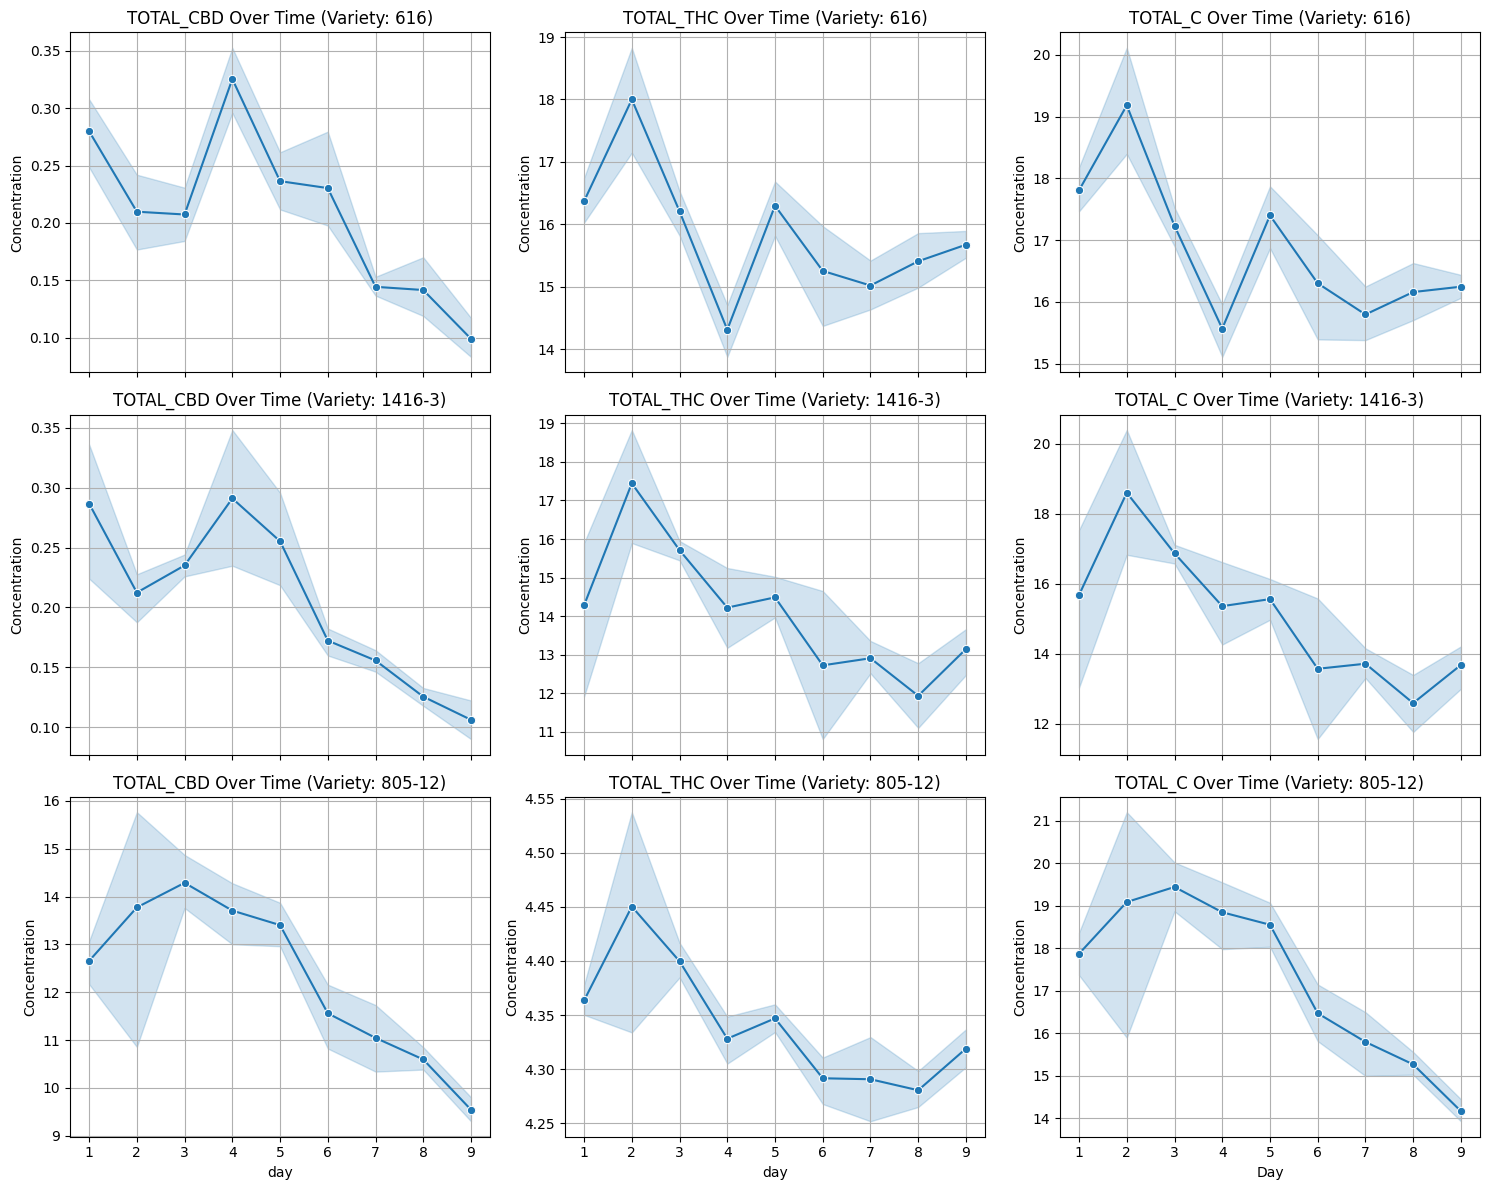

In [5]:
hplc_variables = ["total_cbd", "total_thc", "total_c"]

# Create separate plots for each variety with independent y-axis scales for each HPLC variable
varieties = merged_df["var"].unique()
fig, axes = plt.subplots(len(varieties), len(hplc_variables), figsize=(15, 12), sharex=True)

for row, variety in enumerate(varieties):
    for col, hplc in enumerate(hplc_variables):
        ax = axes[row, col]
        sns.lineplot(data=merged_df[merged_df["var"] == variety], x="day", y=hplc, marker="o", ax=ax)
        ax.set_title(f"{hplc.upper()} Over Time (Variety: {variety})")
        ax.set_ylabel("Concentration")
        ax.grid(True)

# Set common labels
plt.xlabel("Day")
plt.tight_layout()
plt.show()


## Correlation Analysis

In [6]:
corr_columns = ['clear_normalized', 'cloudy_normalized', 'amber_normalized', 
                'total_cbd', 'total_thc', 'total_cbg', 'total_c']

# Define groups of interest
trichome_vars = ['clear_normalized', 'cloudy_normalized', 'amber_normalized']
hplc_vars = ['total_cbd', 'total_thc', 'total_cbg', 'total_c']

### All data together

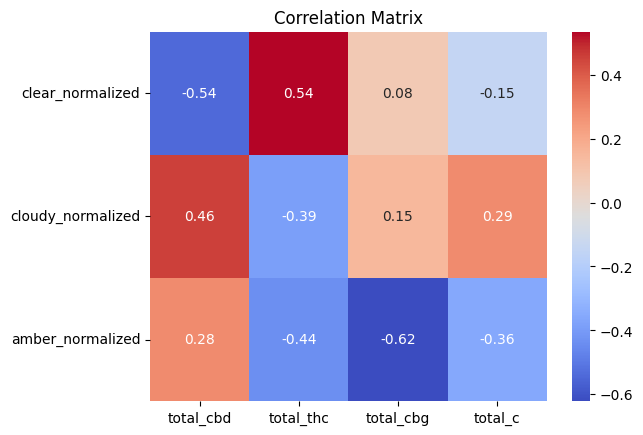

In [32]:
corr_matrix = merged_df[corr_columns].corr()
corr_matrix = corr_matrix.loc[trichome_vars, hplc_vars]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Correlation in each shooting location

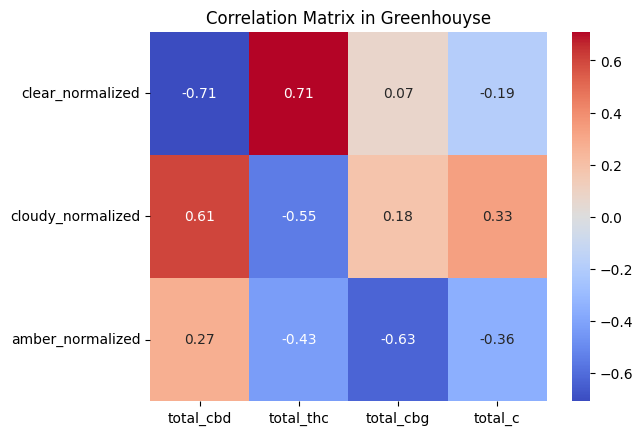

In [33]:
corr_matrix = df_greenhouse[corr_columns].corr()
corr_matrix = corr_matrix.loc[trichome_vars, hplc_vars]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix in Greenhouyse')
plt.show()

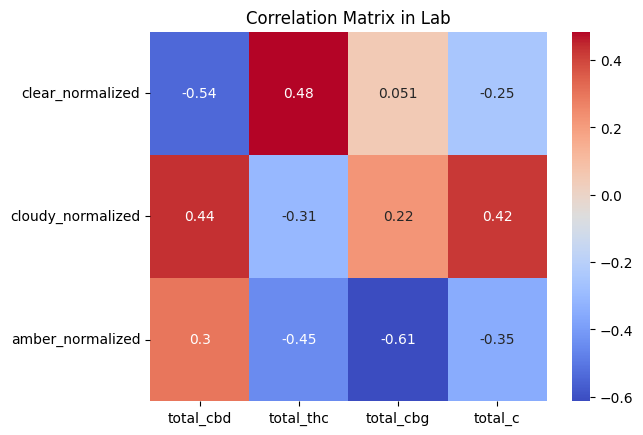

In [34]:
corr_matrix = df_lab[corr_columns].corr()
corr_matrix = corr_matrix.loc[trichome_vars, hplc_vars]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix in Lab')
plt.show()

In [40]:
def plot_variety_heatmaps(df, var_col, corr_columns, trichome_vars, hplc_vars, max_cols=3):
    """
    Plots correlation heatmaps for each unique variety in the dataset.
    """
    # Get the unique varieties
    variations = df[var_col].unique()
    num_vars = len(variations)

    # Determine grid layout
    cols = min(num_vars, max_cols)
    rows = (num_vars // cols) + (num_vars % cols > 0)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

    # Flatten axes array if needed
    if num_vars > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Convert single axis to list for iteration

    # Loop over each variety and generate the heatmap
    for i, var in enumerate(variations):
        df_var = df[df[var_col] == var]  # Subset the data
        corr_matrix = df_var[corr_columns].corr()  # Compute correlation matrix
        corr_matrix = corr_matrix.loc[trichome_vars, hplc_vars]  # Select specific correlations

        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
        axes[i].set_title(f'Correlation for Variety: {var}')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()


#### Corr matrix for variations in both shooting locations

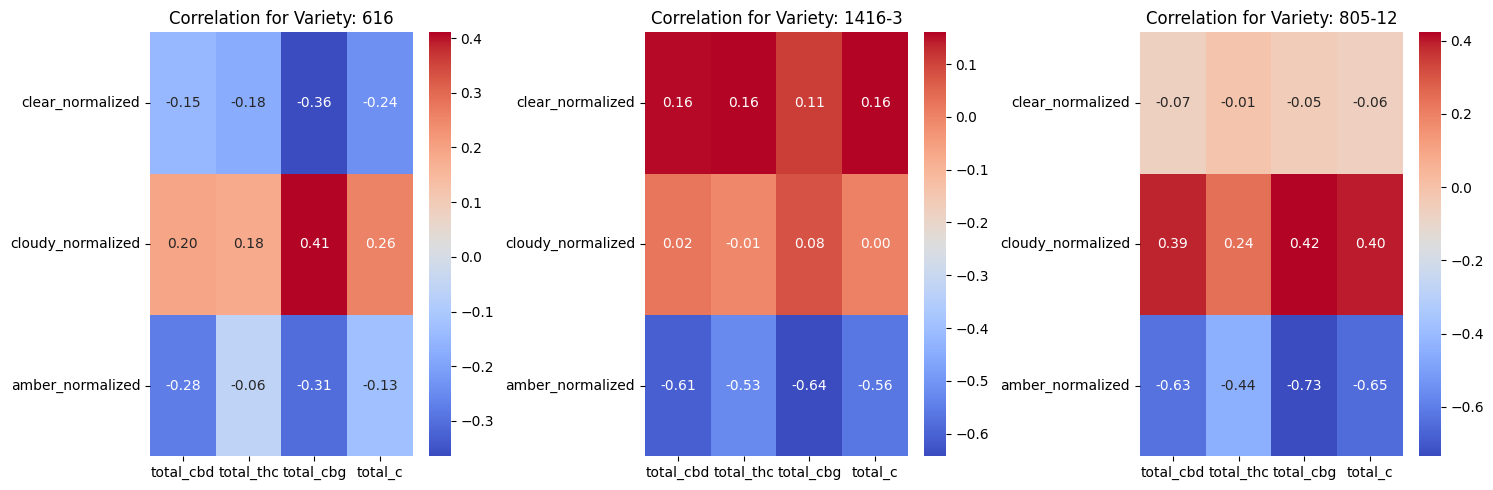

In [42]:
plot_variety_heatmaps(merged_df, 'var', corr_columns, trichome_vars, hplc_vars)

#### Corr matrix for variations in Greenhouse

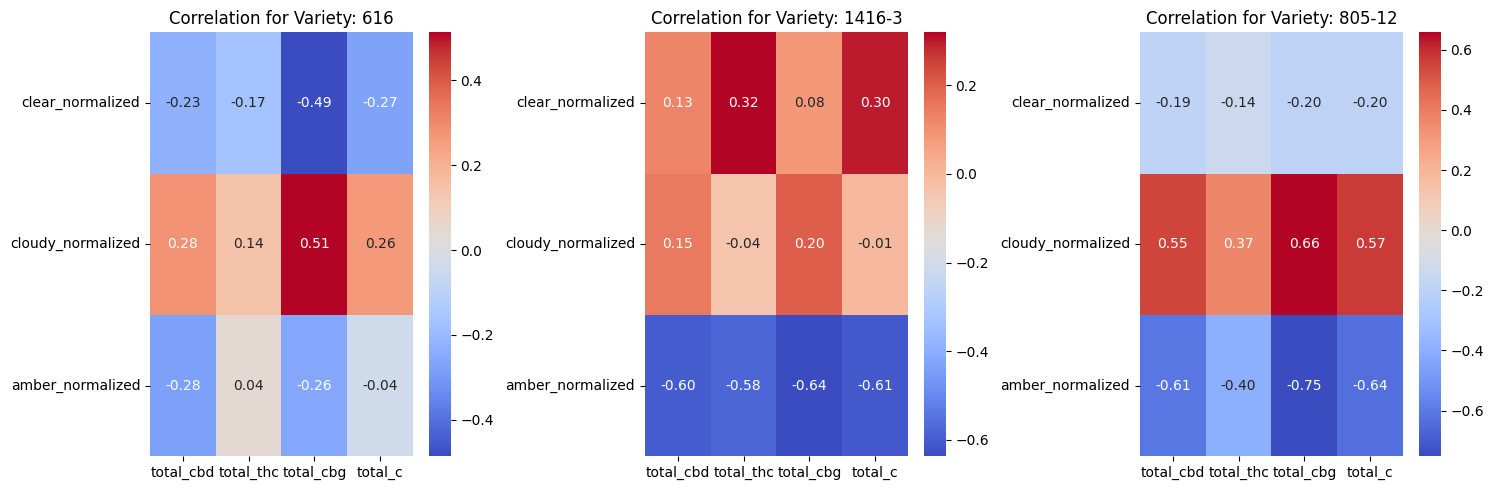

In [43]:
plot_variety_heatmaps(df_greenhouse, 'var', corr_columns, trichome_vars, hplc_vars)

#### Corr matrix for variations in Lab

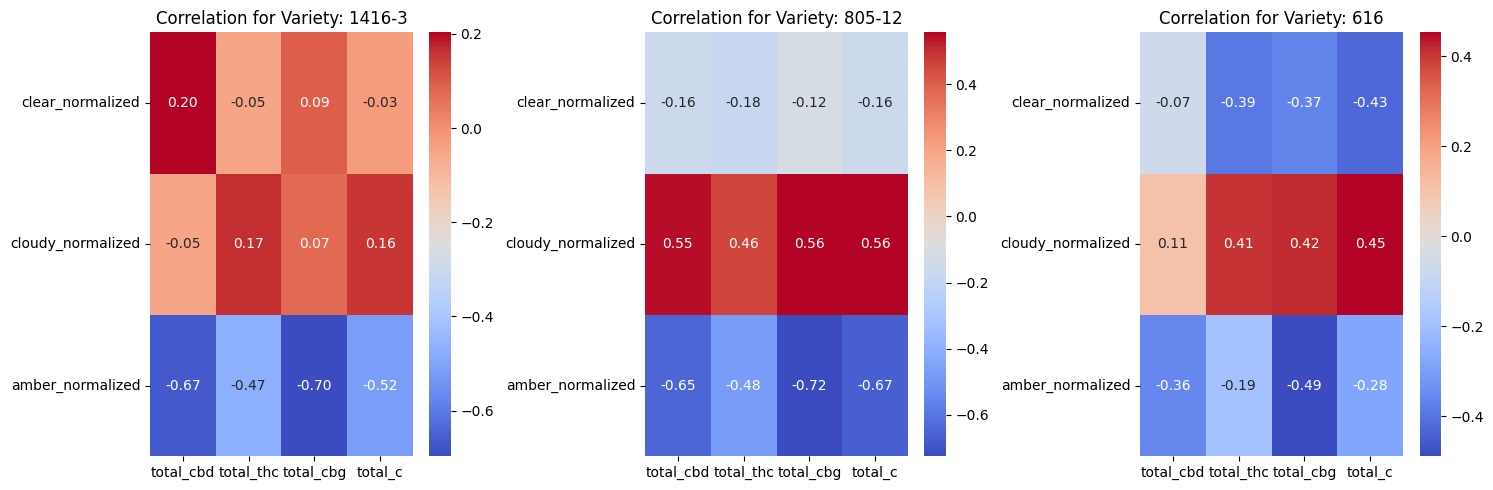

In [44]:
plot_variety_heatmaps(df_lab, 'var', corr_columns, trichome_vars, hplc_vars)

### Corr Matrix of only statistical signficant (p < 0.05) Values

In [7]:
def plot_variety_heatmaps_fixed_scale(df, var_col, trichome_vars, hplc_vars, max_cols=3):
    """
    Plots correlation heatmaps with p-values for each unique variety in the dataset,
    ensuring the color scale is fixed between -1 and 1.
    """
    # Get the unique varieties
    variations = df[var_col].unique()
    num_vars = len(variations)

    # Determine grid layout
    cols = min(num_vars, max_cols)
    rows = (num_vars // cols) + (num_vars % cols > 0)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

    # Flatten axes array if needed
    if num_vars > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Convert single axis to list for iteration

    # Loop over each variety and generate the heatmap
    for i, var in enumerate(variations):
        df_var = df[df[var_col] == var]  # Subset the data

        # Compute correlation and p-value matrices
        corr_matrix = np.zeros((len(trichome_vars), len(hplc_vars)))
        pval_matrix = np.ones((len(trichome_vars), len(hplc_vars)))

        for t_idx, trichome_var in enumerate(trichome_vars):
            for h_idx, hplc_var in enumerate(hplc_vars):
                if df_var[trichome_var].isnull().any() or df_var[hplc_var].isnull().any():
                    continue  # Skip if there are NaN values
                corr, p_value = stats.pearsonr(df_var[trichome_var], df_var[hplc_var])
                corr_matrix[t_idx, h_idx] = corr
                pval_matrix[t_idx, h_idx] = p_value

        # Mask non-significant correlations (p > 0.05)
        mask = pval_matrix > 0.05

        # Create heatmap with fixed color scale (-1 to 1)
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
                    mask=mask, ax=axes[i], linewidths=0.5, cbar=True, vmin=-1, vmax=1)
        
        axes[i].set_title(f'Correlation for Variety: {var}')
        axes[i].set_xticklabels(hplc_vars, rotation=45, ha='right')
        axes[i].set_yticklabels(trichome_vars, rotation=0)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()


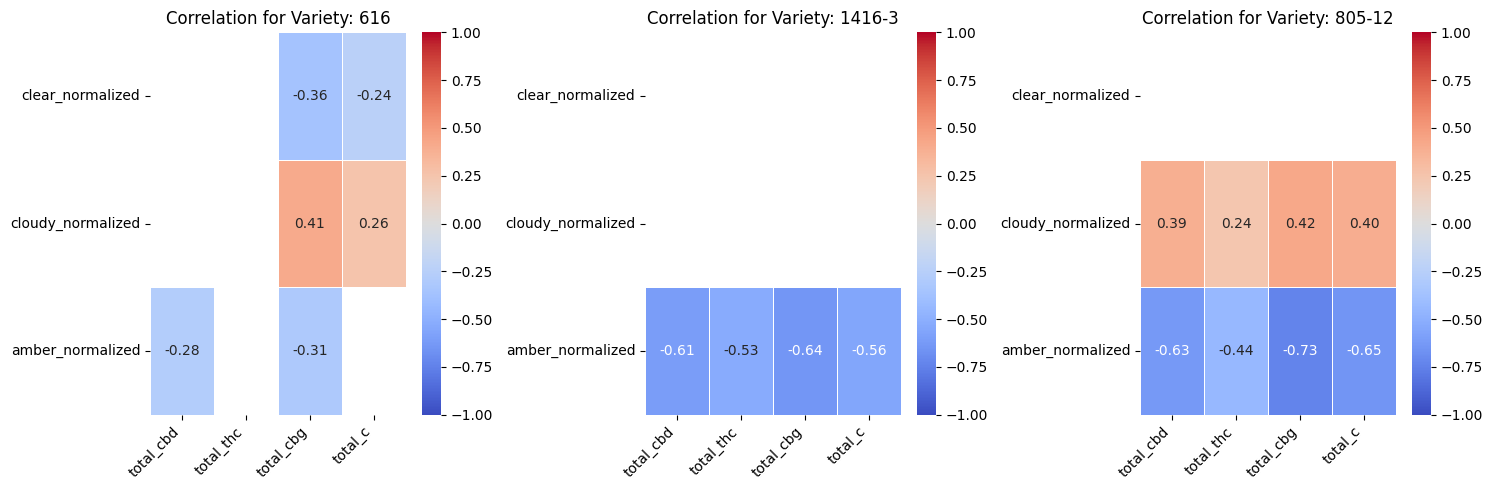

In [10]:
var_col = "var"
normalized_trichome_vars = ["clear_normalized", "cloudy_normalized", "amber_normalized"]
import scipy.stats as stats

# Generate the plots again with fixed color scale (-1 to 1)
plot_variety_heatmaps_fixed_scale(merged_df, var_col, normalized_trichome_vars, hplc_vars)

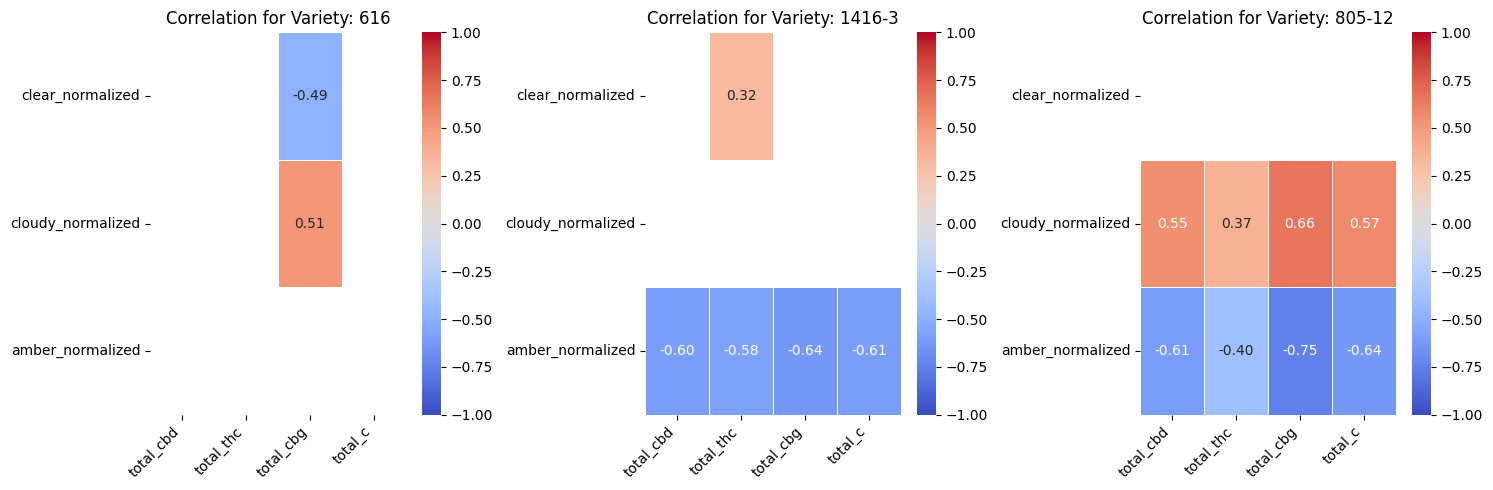

In [11]:
# Generate the plots again with fixed color scale (-1 to 1)
plot_variety_heatmaps_fixed_scale(df_greenhouse, var_col, normalized_trichome_vars, hplc_vars)

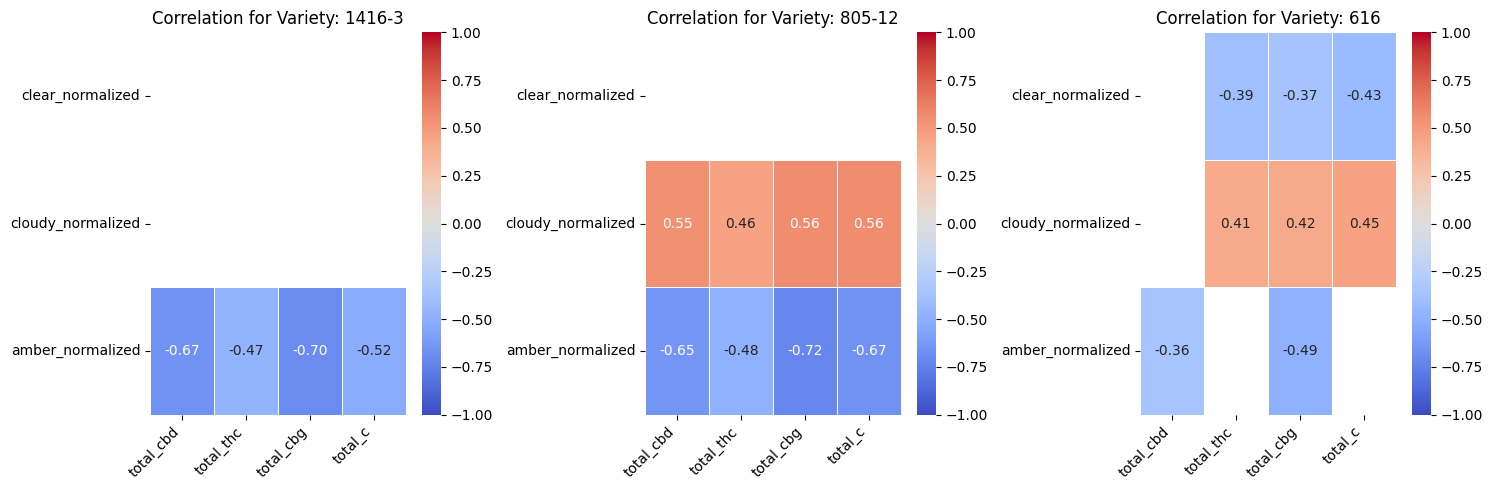

In [12]:
# Generate the plots again with fixed color scale (-1 to 1)
plot_variety_heatmaps_fixed_scale(df_lab, var_col, normalized_trichome_vars, hplc_vars)

### Correlation over Time

In [6]:
# Calculate rolling correlation over time using a different approach
time_correlation_results = []

# Iterate over each day and compute correlations
for day, group in merged_df.groupby("day"):
    correlation_matrix = group[["clear_normalized", "cloudy_normalized", "amber_normalized", 
                                "total_cbd", "total_thc", "total_c"]].corr()
    
    # Extract correlations between trichome distributions and cannabinoids
    for trichome in ["clear_normalized", "cloudy_normalized", "amber_normalized"]:
        for cannabinoid in ["total_cbd", "total_thc", "total_c"]:
            time_correlation_results.append({
                "day": day,
                "trichome_type": trichome,
                "cannabinoid": cannabinoid,
                "correlation": correlation_matrix.loc[trichome, cannabinoid]
            })

# Convert results into a DataFrame
time_correlation_df = pd.DataFrame(time_correlation_results)
time_correlation_df


day      trichome_type cannabinoid  correlation
0     1   clear_normalized   total_cbd    -0.496847
1     1   clear_normalized   total_thc     0.425171
2     1   clear_normalized     total_c    -0.196722
3     1  cloudy_normalized   total_cbd     0.477563
4     1  cloudy_normalized   total_thc    -0.408526
..  ...                ...         ...          ...
76    9  cloudy_normalized   total_thc    -0.322465
77    9  cloudy_normalized     total_c    -0.196232
78    9   amber_normalized   total_cbd     0.803365
79    9   amber_normalized   total_thc    -0.867818
80    9   amber_normalized     total_c    -0.576175

[81 rows x 4 columns]

### Correlation over time

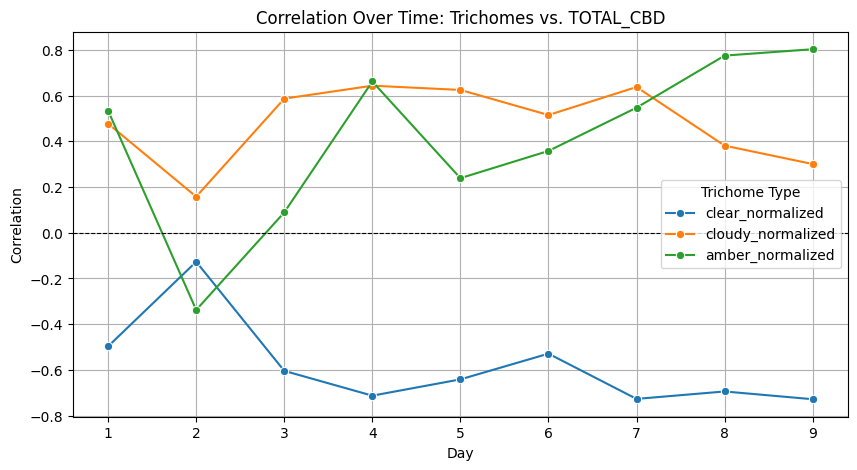

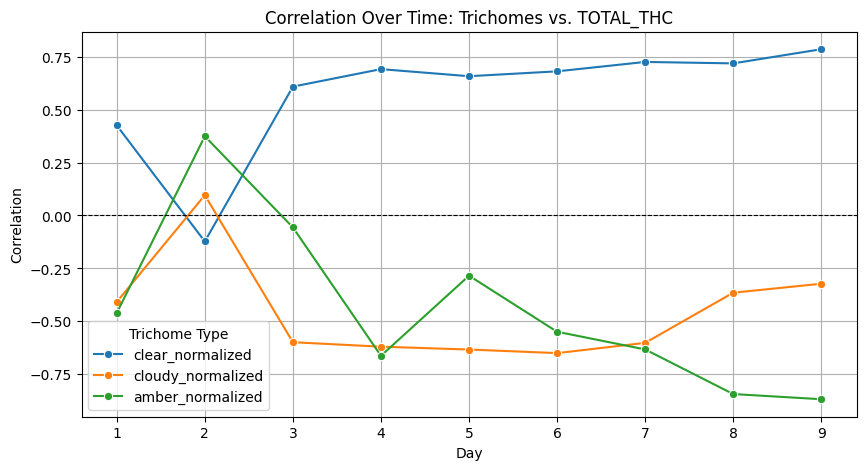

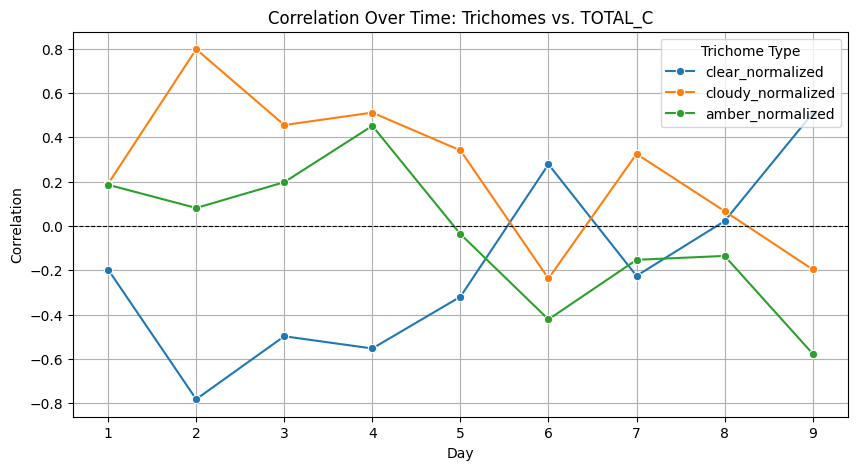

In [7]:
# Define cannabinoids for separate plots
cannabinoids = ["total_cbd", "total_thc", "total_c"]

# Plot each cannabinoid separately
for cannabinoid in cannabinoids:
    plt.figure(figsize=(10, 5))
    subset = time_correlation_df[time_correlation_df["cannabinoid"] == cannabinoid]
    sns.lineplot(data=subset, x="day", y="correlation", hue="trichome_type", marker="o")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.title(f"Correlation Over Time: Trichomes vs. {cannabinoid.upper()}")
    plt.xlabel("Day")
    plt.ylabel("Correlation")
    plt.legend(title="Trichome Type")
    plt.grid(True)
    plt.show()


### Correlation Over Time by Variety

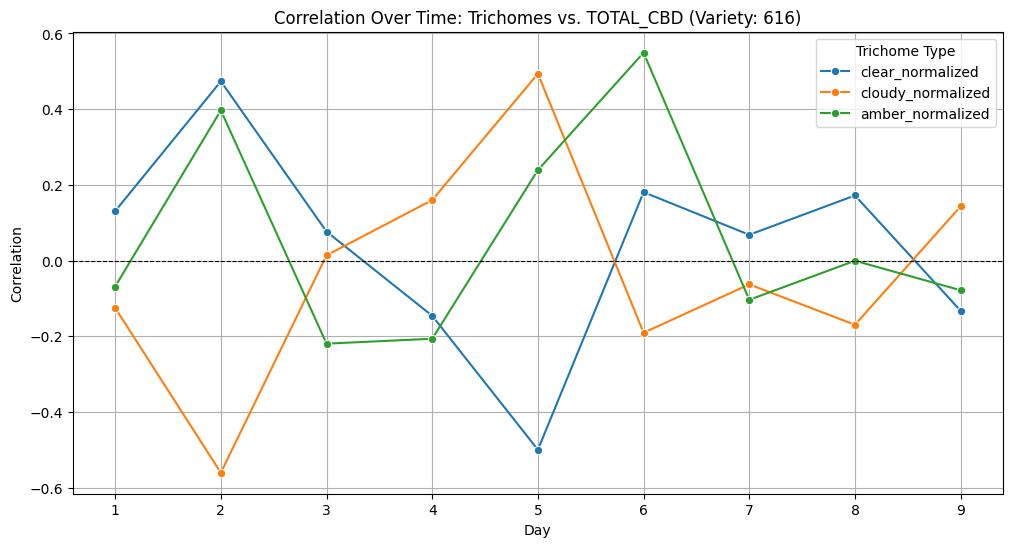

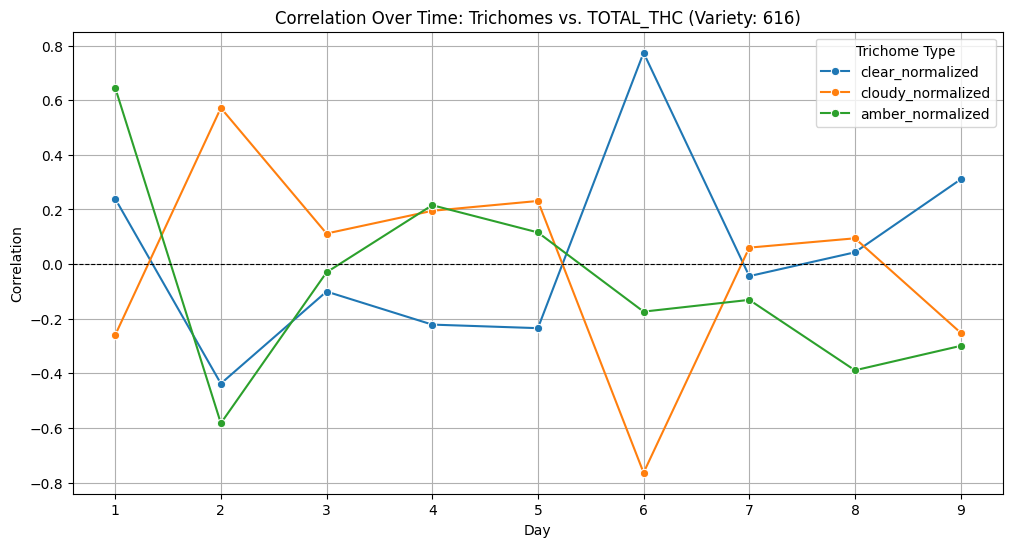

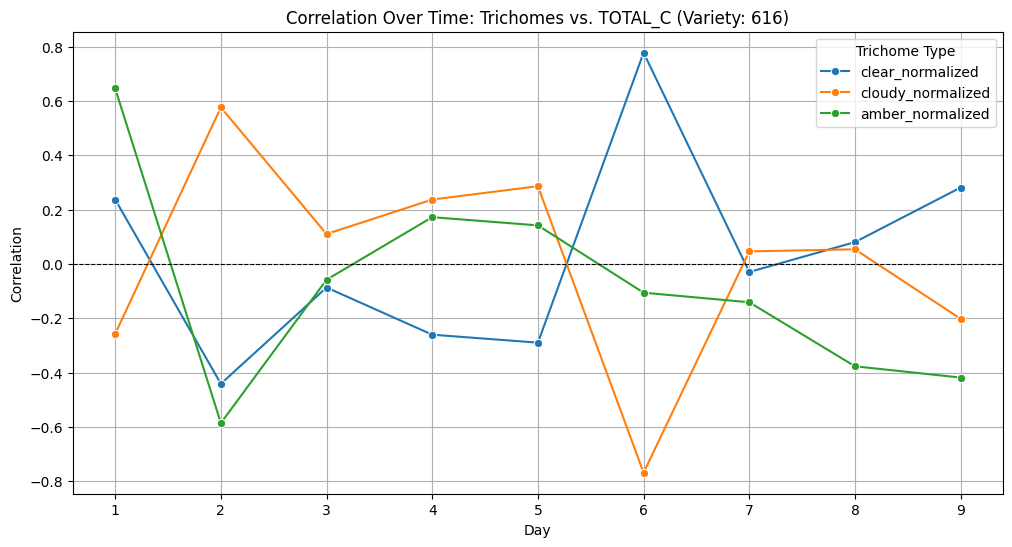

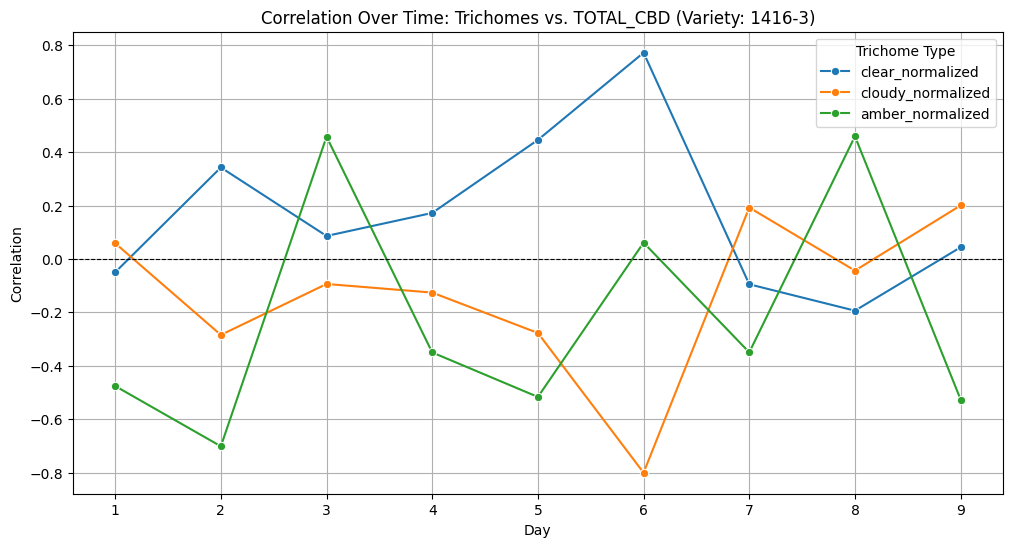

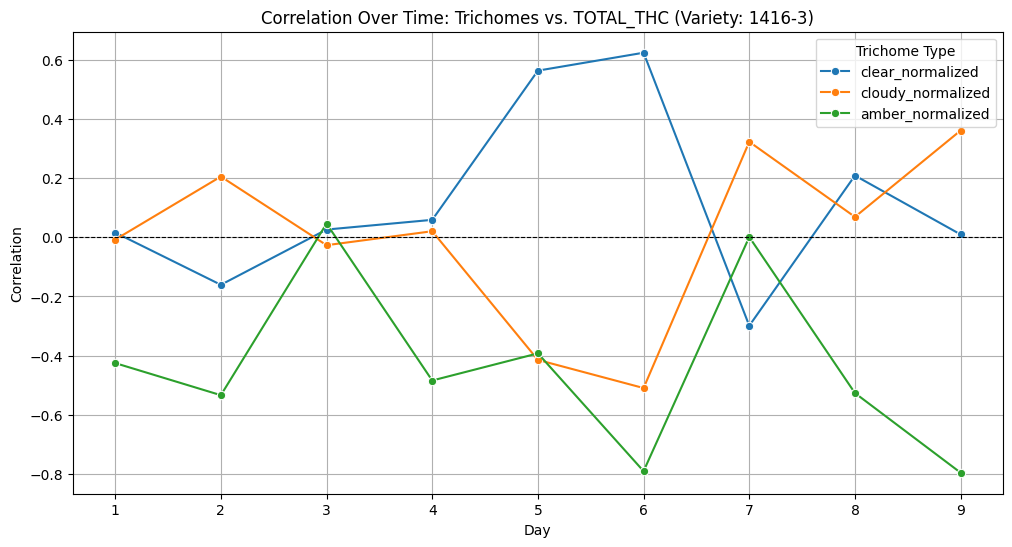

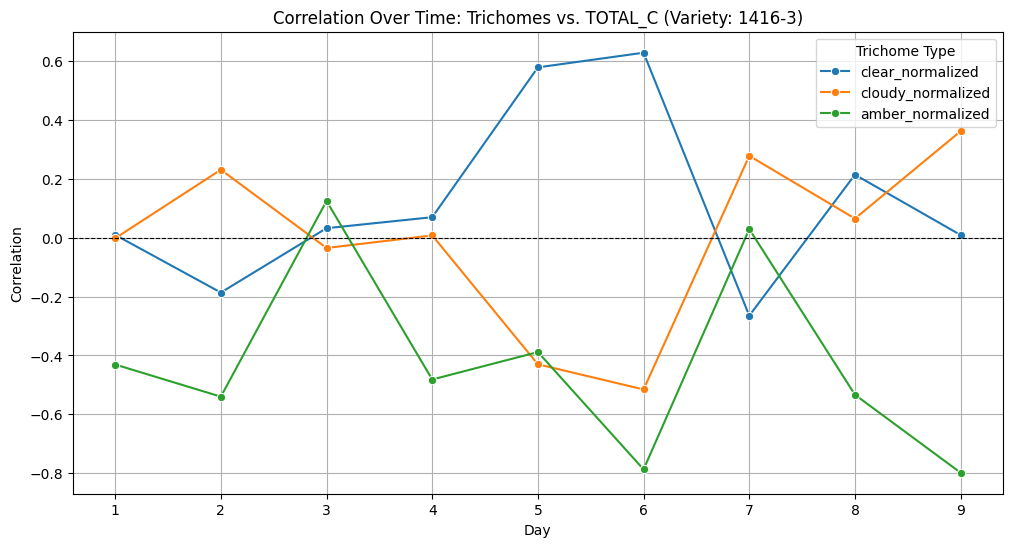

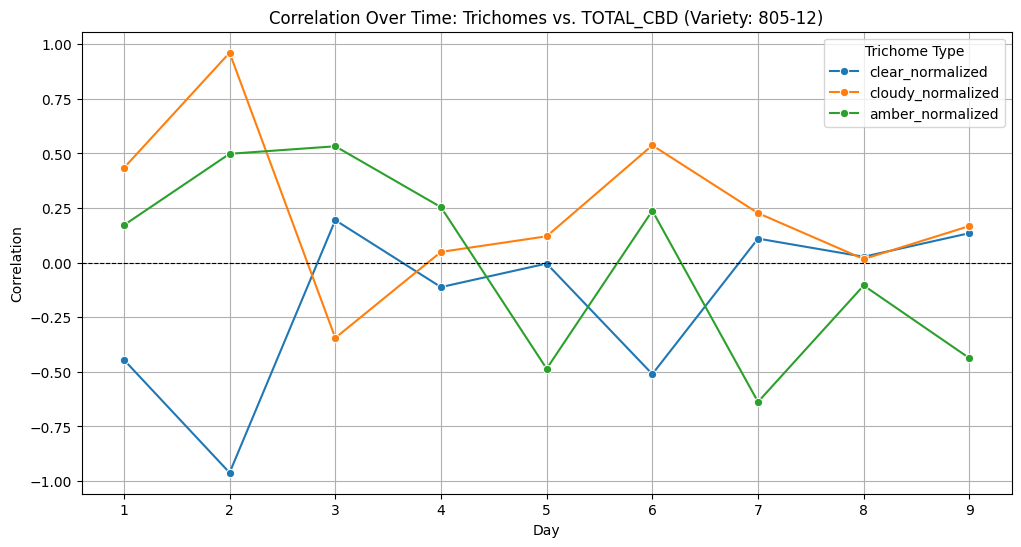

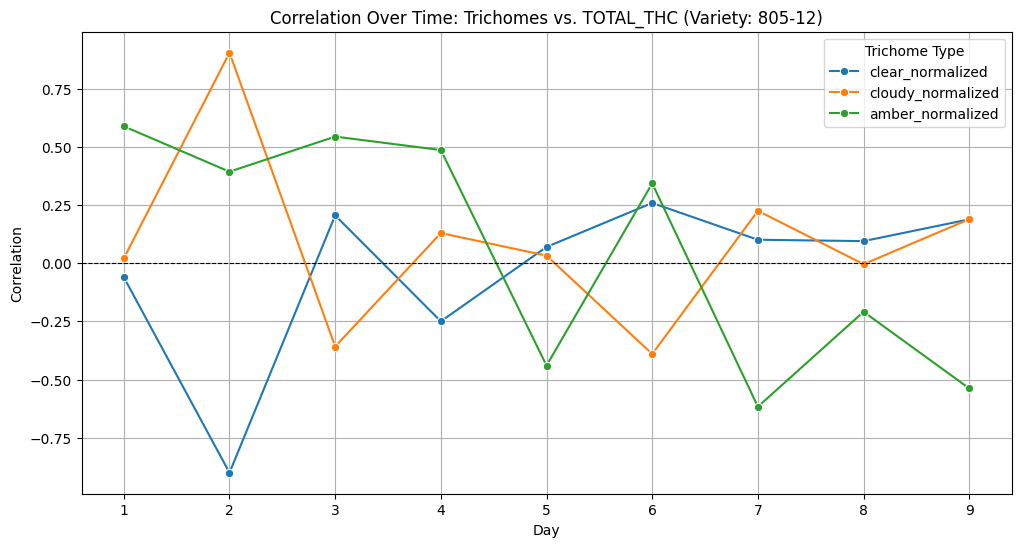

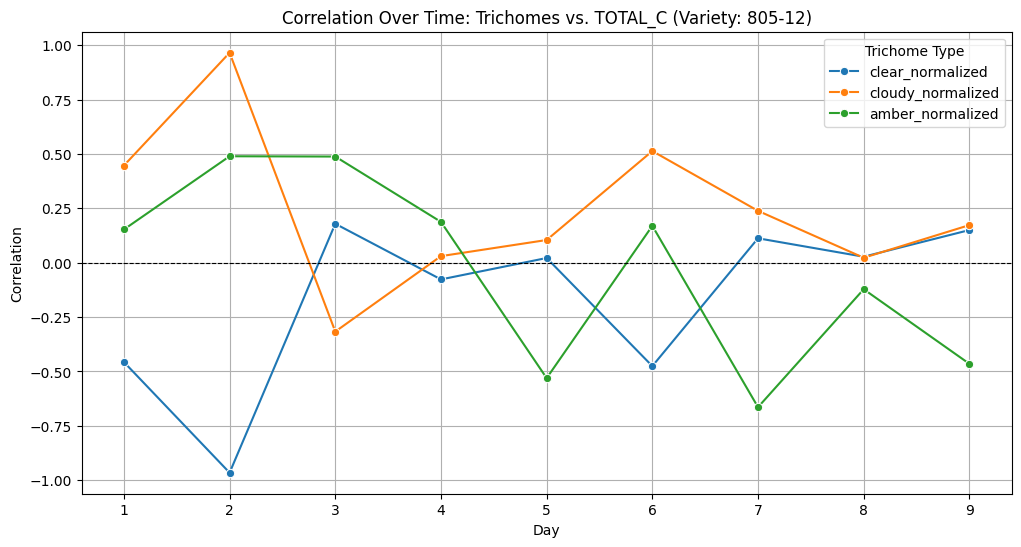

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate rolling correlation over time for different varieties
time_correlation_results = []

# Iterate over each variety and day to compute correlations
for variety, variety_group in merged_df.groupby("var"):
    for day, day_group in variety_group.groupby("day"):
        correlation_matrix = day_group[["clear_normalized", "cloudy_normalized", "amber_normalized", 
                                        "total_cbd", "total_thc", "total_c"]].corr()
        
        # Extract correlations between trichome distributions and cannabinoids
        for trichome in ["clear_normalized", "cloudy_normalized", "amber_normalized"]:
            for cannabinoid in ["total_cbd", "total_thc", "total_c"]:
                time_correlation_results.append({
                    "variety": variety,
                    "day": day,
                    "trichome_type": trichome,
                    "cannabinoid": cannabinoid,
                    "correlation": correlation_matrix.loc[trichome, cannabinoid]
                })

# Convert results into a DataFrame
time_correlation_df = pd.DataFrame(time_correlation_results)

# Plot correlation over time for different varieties
cannabinoids = ["total_cbd", "total_thc", "total_c"]

# Plot correlation over time separately for each variety
for variety in time_correlation_df["variety"].unique():
    for cannabinoid in cannabinoids:
        plt.figure(figsize=(12, 6))
        subset = time_correlation_df[(time_correlation_df["variety"] == variety) & 
                                    (time_correlation_df["cannabinoid"] == cannabinoid)]
        sns.lineplot(data=subset, x="day", y="correlation", hue="trichome_type", marker="o")
        plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
        plt.title(f"Correlation Over Time: Trichomes vs. {cannabinoid.upper()} (Variety: {variety})")
        plt.xlabel("Day")
        plt.ylabel("Correlation")
        plt.legend(title="Trichome Type")
        plt.grid(True)
        plt.show()



### Changes of the variables over time

In [25]:
# Define variables for analysis
cannabinoids = ["total_cbd", "total_thc", "total_cbg", "total_c"]
trichome_counts = ["clear_normalized", "cloudy_normalized", "amber_normalized"]
split_factors = ["location", "var"]

# Extract the relevant columns for analysis
selected_columns = ["day", "location", "var"] + trichome_counts + cannabinoids

# Filter and sort data
split_value_df = merged_df[selected_columns].sort_values(by=["day", "location", "var"])

# Define variables for plotting
split_categories = split_value_df["location"].unique()
flower_variations = split_value_df["var"].unique()


In [66]:
cannabinoids

['total_cbd', 'total_thc', 'total_cbg', 'total_c']

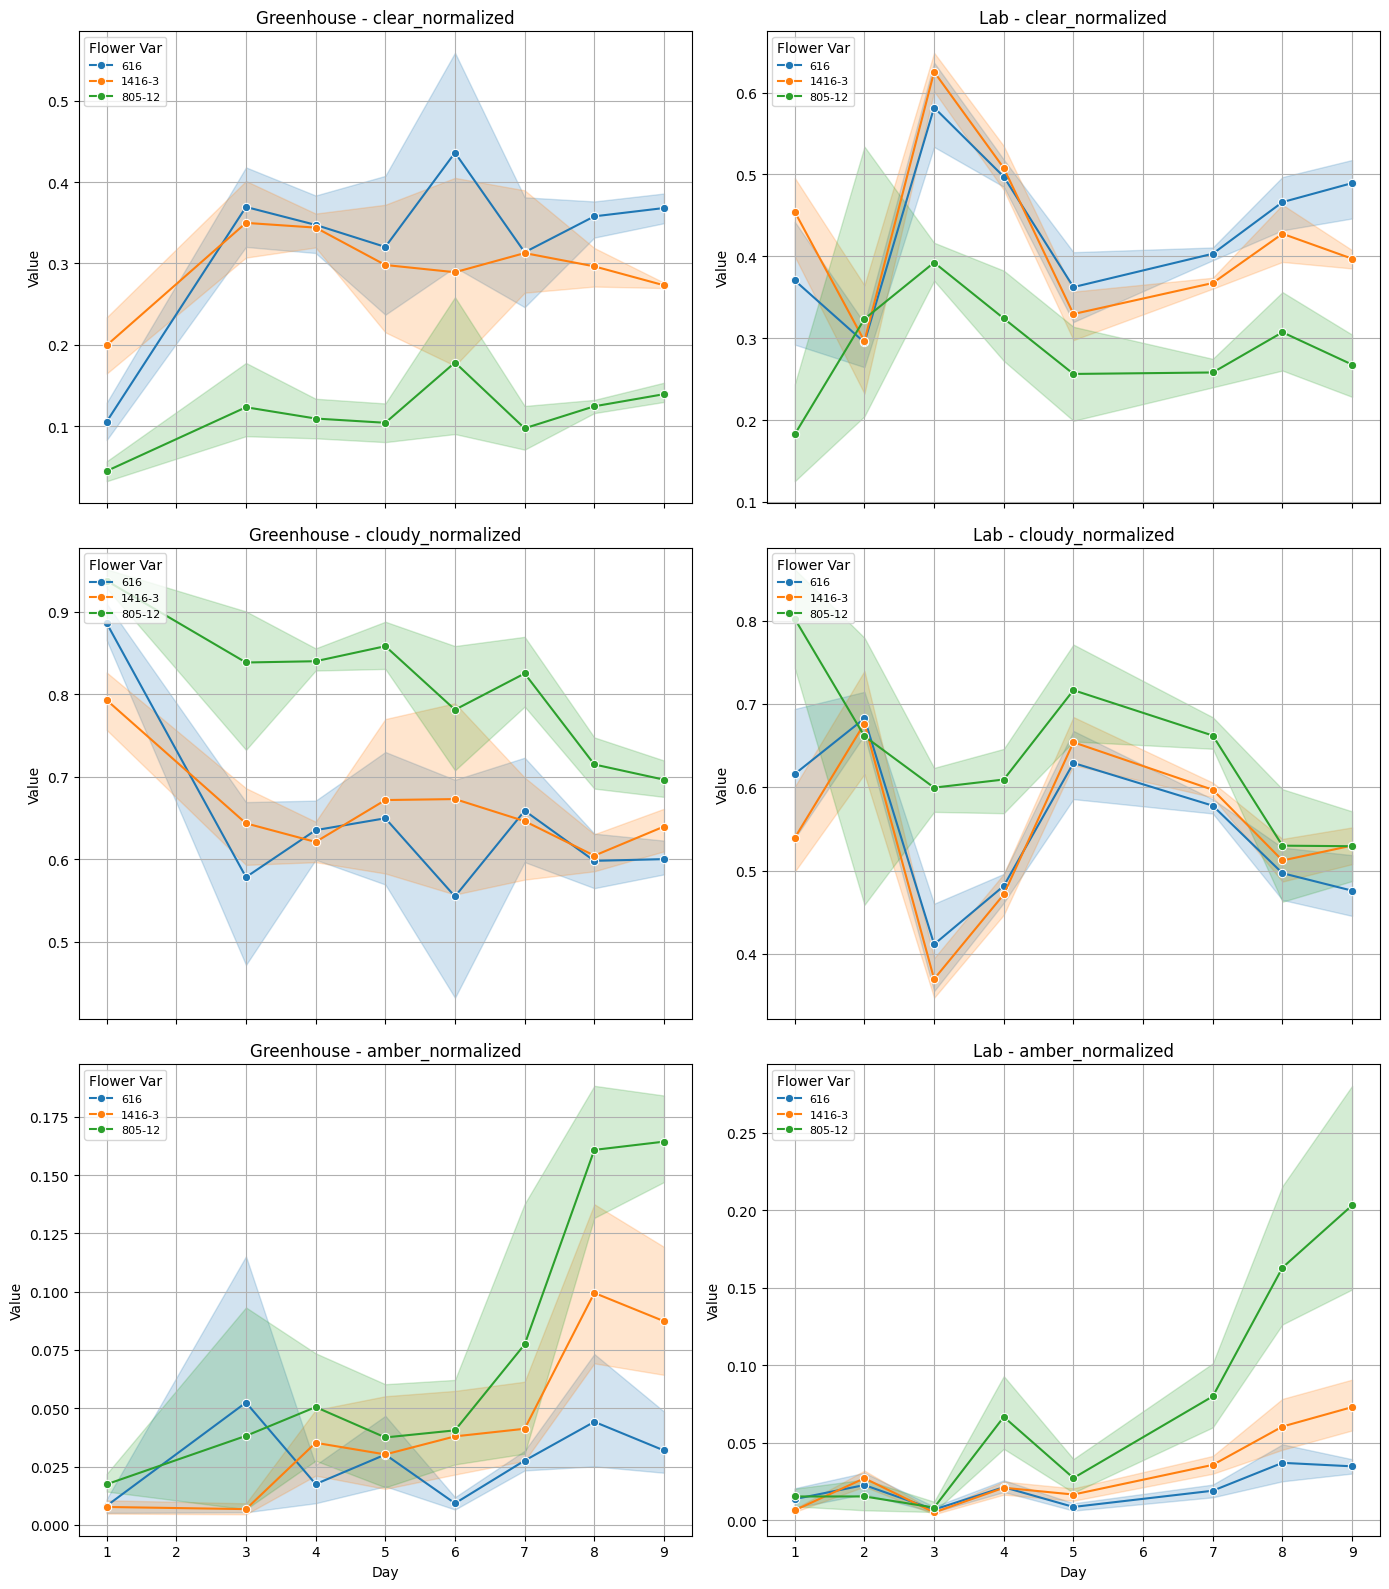

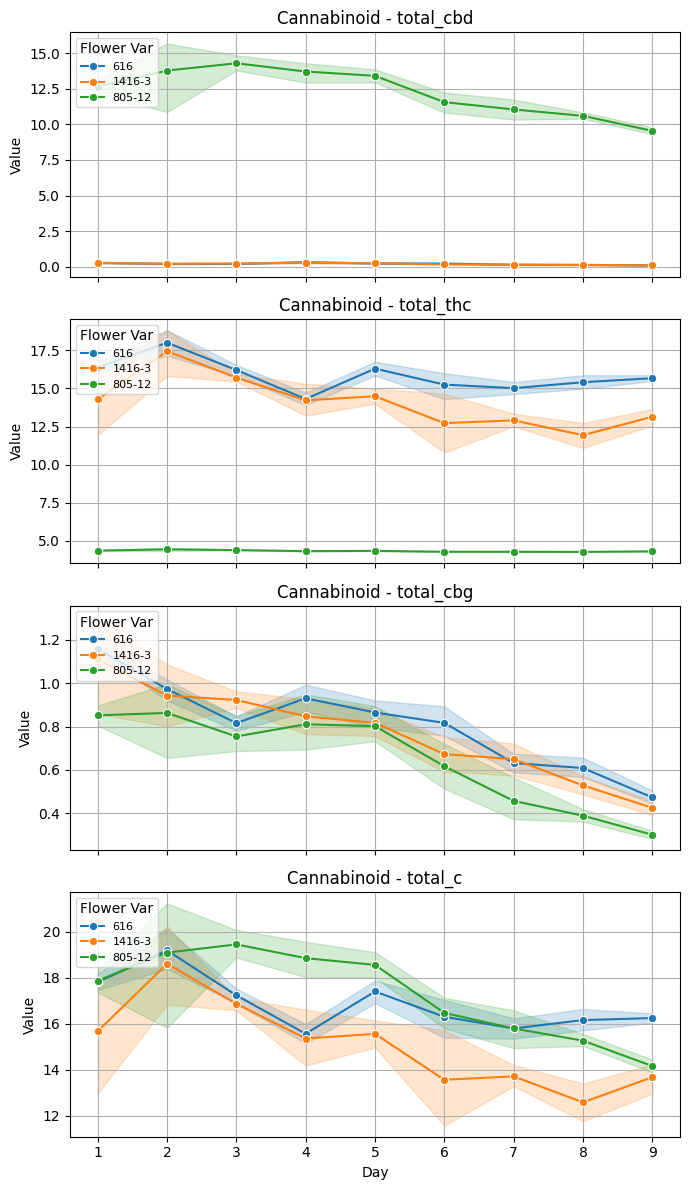

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of rows
num_trichomes = len(trichome_counts)
num_cannabinoids = len(cannabinoids)

# Create a figure with 2 columns: 
# - Left column for greenhouse trichome plots
# - Right column for lab trichome plots
fig, axes = plt.subplots(num_trichomes, 2, figsize=(14, 16), sharex=True, gridspec_kw={'width_ratios': [1, 1]})


# Plot trichome-related variables (split by location)
for idx, variable in enumerate(trichome_counts):
    for col_idx, location in enumerate(split_categories):  # Greenhouse / Lab
        ax = axes[idx, col_idx]
        subset_location = split_value_df[split_value_df["location"] == location]

        for flower_var in flower_variations:
            subset = subset_location[subset_location["var"] == flower_var]
            if not subset.empty:
                sns.lineplot(data=subset, x="day", y=variable, label=f"{flower_var}", marker="o", ax=ax)

        ax.set_title(f"{location.capitalize()} - {variable}")
        ax.set_xlabel("Day")
        ax.set_ylabel("Value")
        ax.legend(title="Flower Var", fontsize=8, loc="upper left")
        ax.grid(True)

# Add a separate **full-width** subplot for cannabinoids
fig_cannabinoids, ax_cannabinoids = plt.subplots(len(cannabinoids), 1, figsize=(7, len(cannabinoids) * 3), sharex=True)

# Flatten axes in case there's only one row
if len(cannabinoids) == 1:
    ax_cannabinoids = [ax_cannabinoids]

# Plot cannabinoid-related variables (only once, not split by location)
for idx, variable in enumerate(cannabinoids):
    for flower_var in flower_variations:
        subset = split_value_df[split_value_df["var"] == flower_var]
        if not subset.empty:
            sns.lineplot(data=subset, x="day", y=variable, label=f"{flower_var}", marker="o", ax=ax_cannabinoids[idx])

    ax_cannabinoids[idx].set_title(f"Cannabinoid - {variable}")
    ax_cannabinoids[idx].set_xlabel("Day")
    ax_cannabinoids[idx].set_ylabel("Value")
    ax_cannabinoids[idx].legend(title="Flower Var", fontsize=8, loc="upper left")
    ax_cannabinoids[idx].grid(True)

# Adjust layout
plt.tight_layout()
fig.tight_layout()
fig_cannabinoids.tight_layout()
plt.show()


### Variables Over Time with each Variable Scale

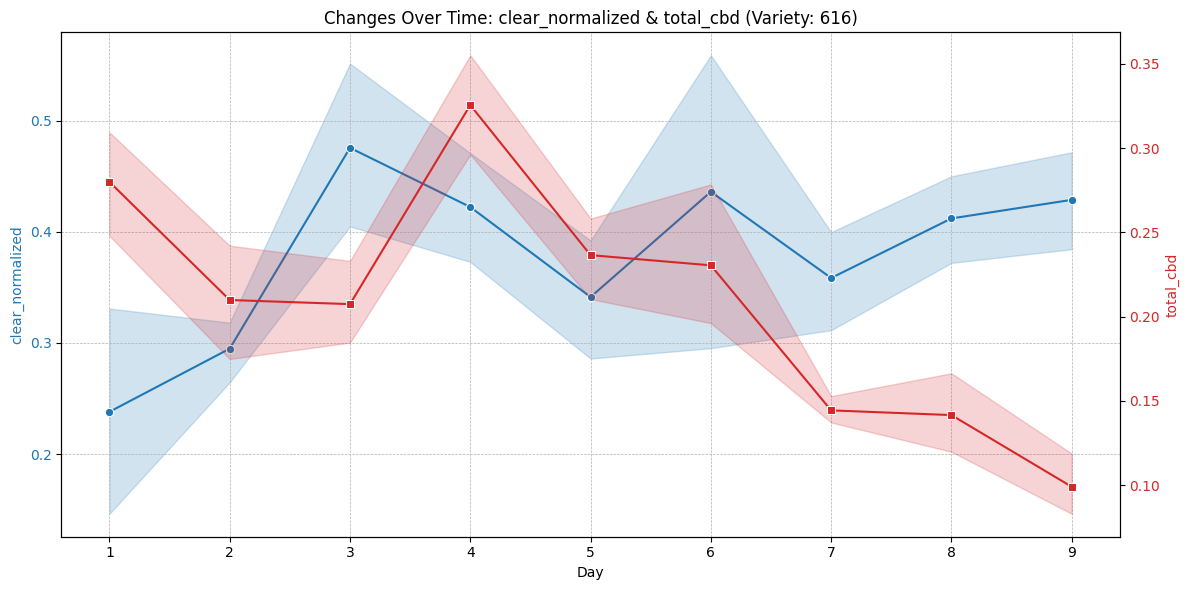

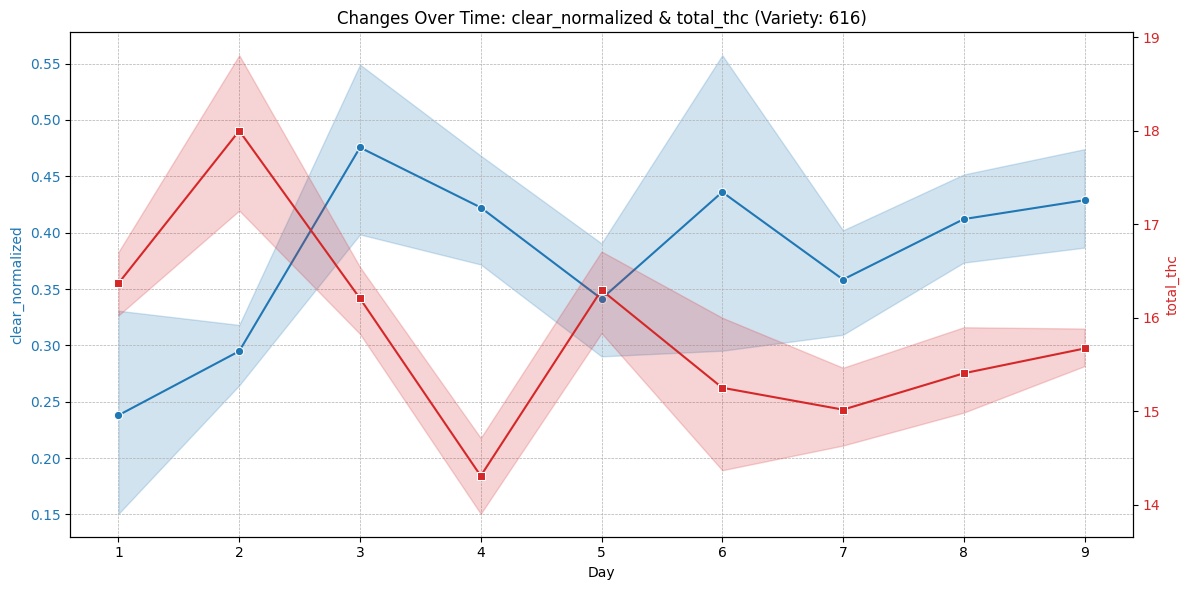

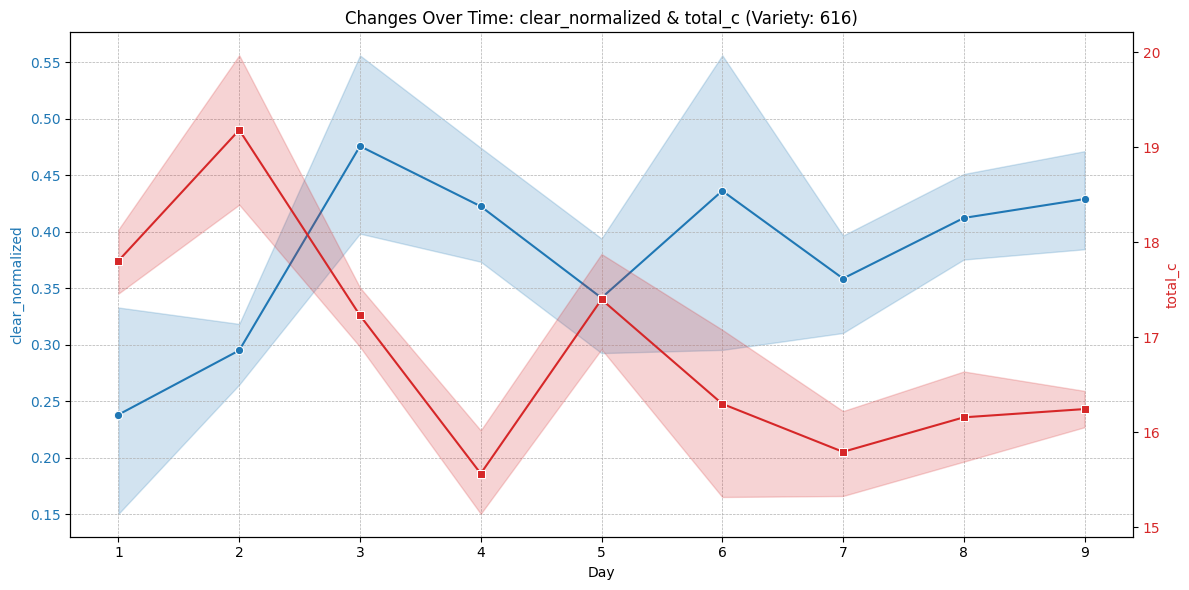

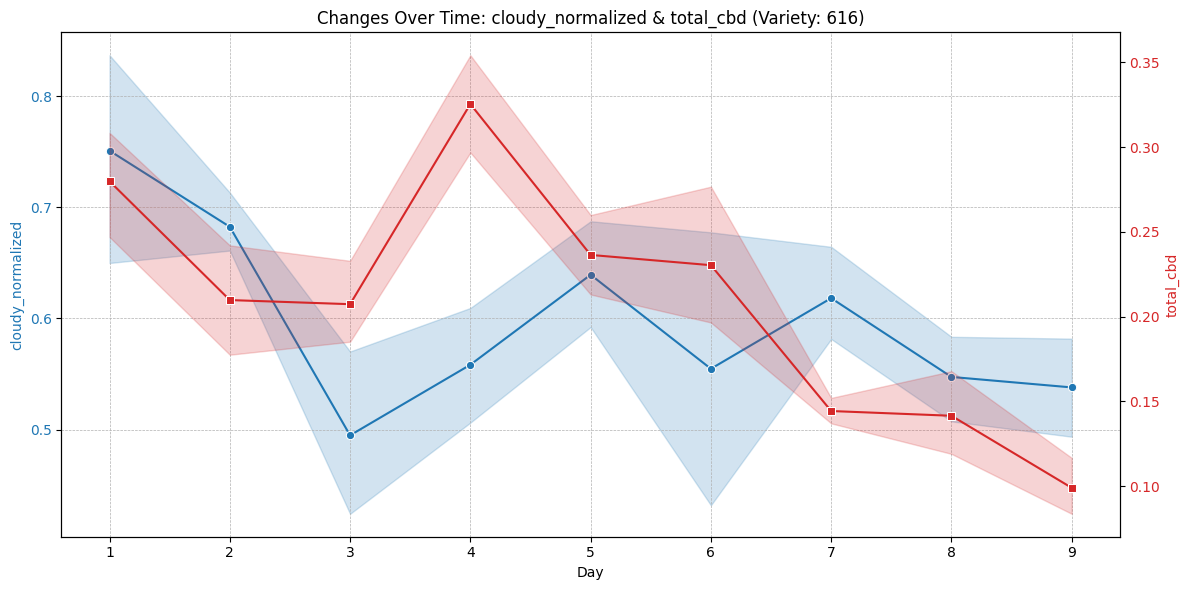

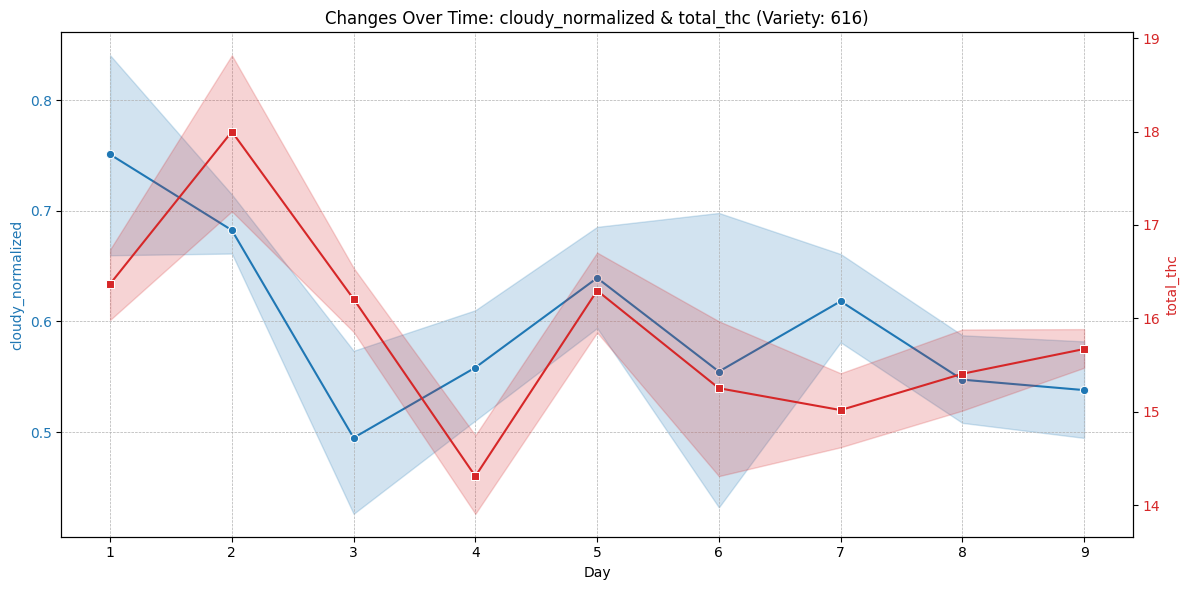

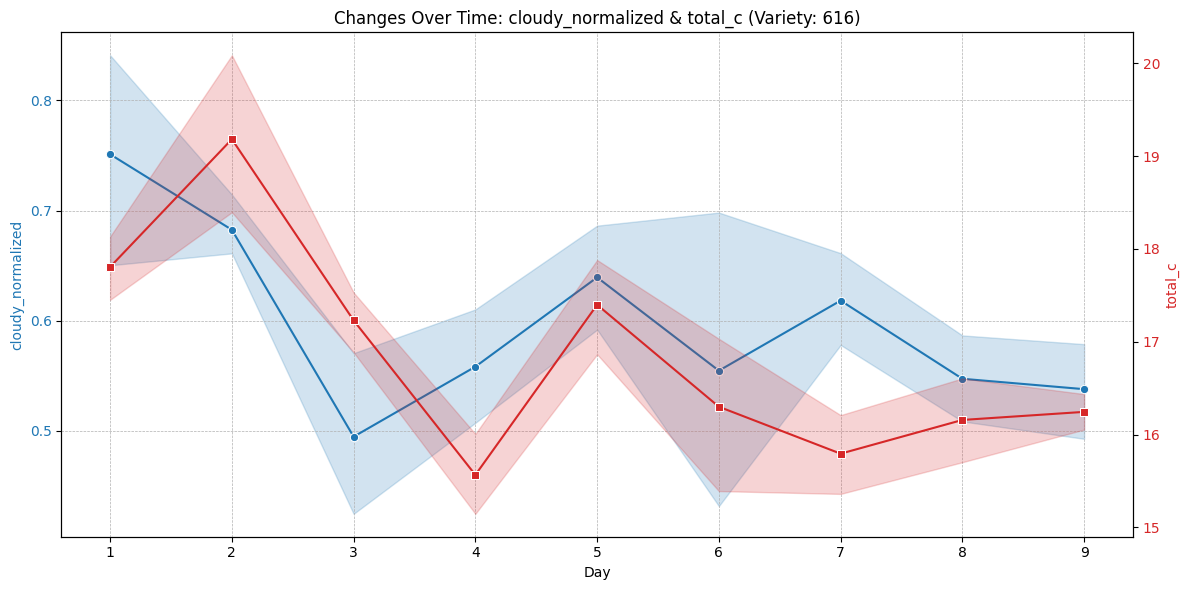

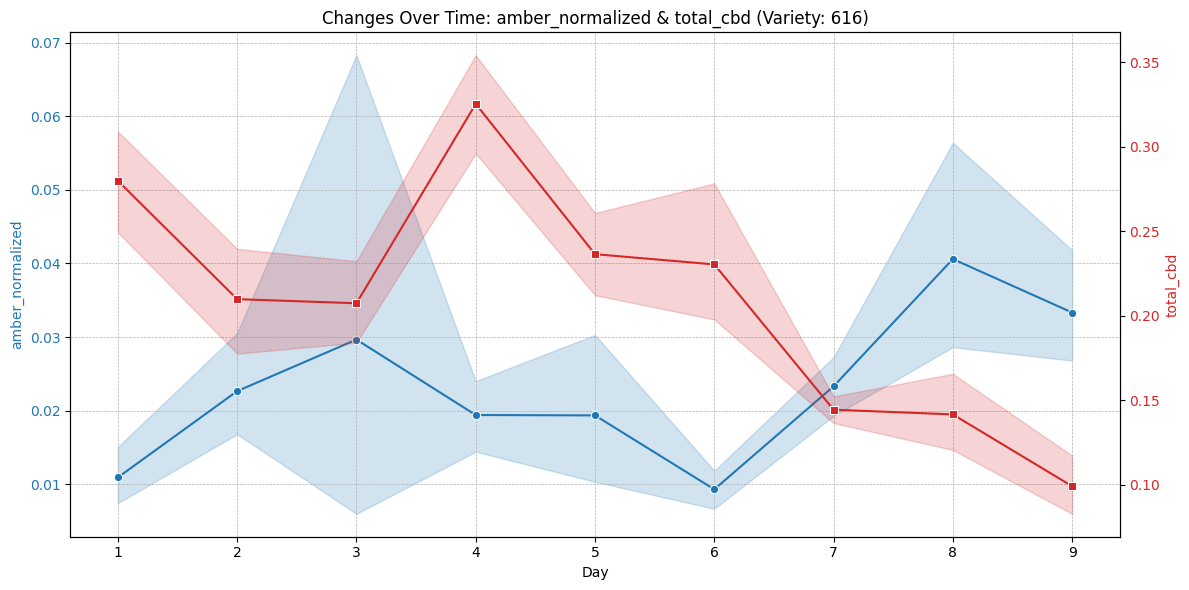

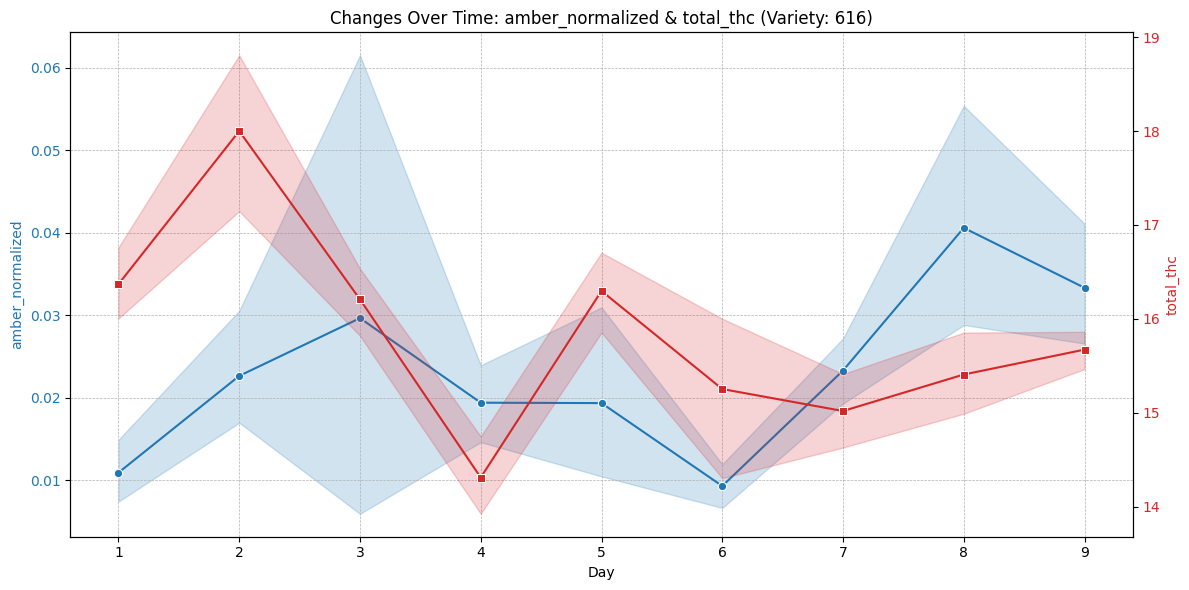

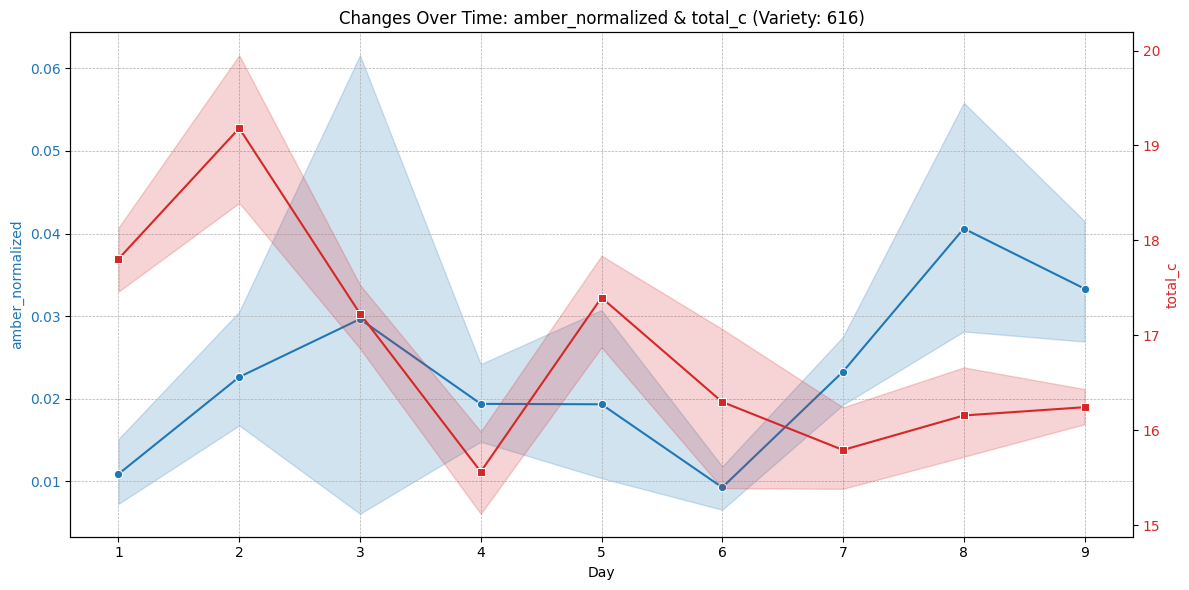

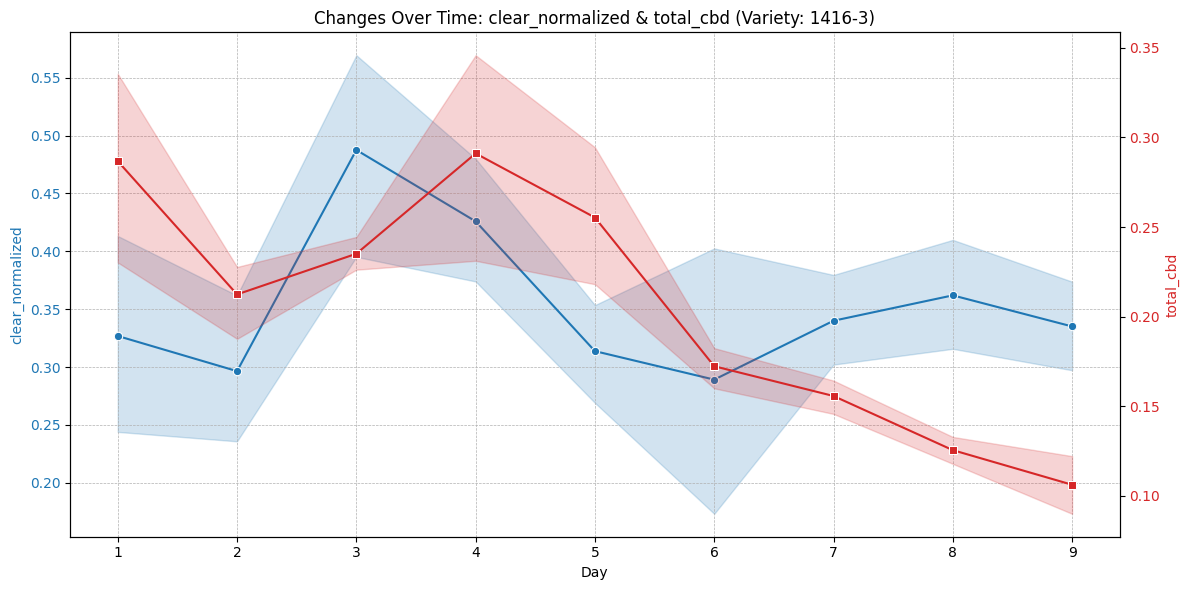

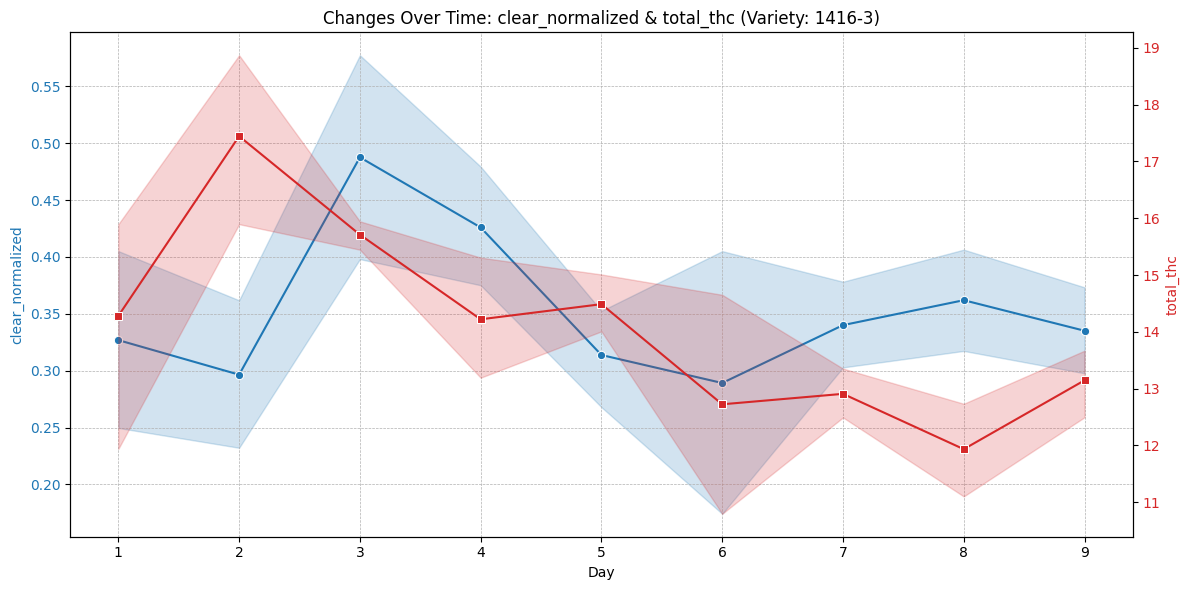

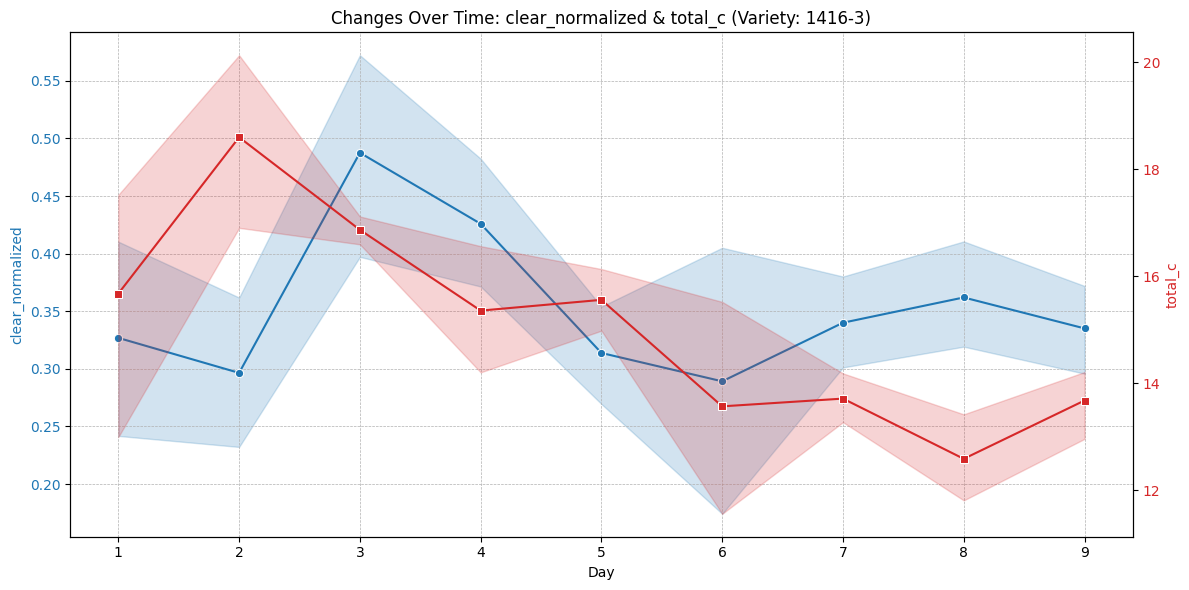

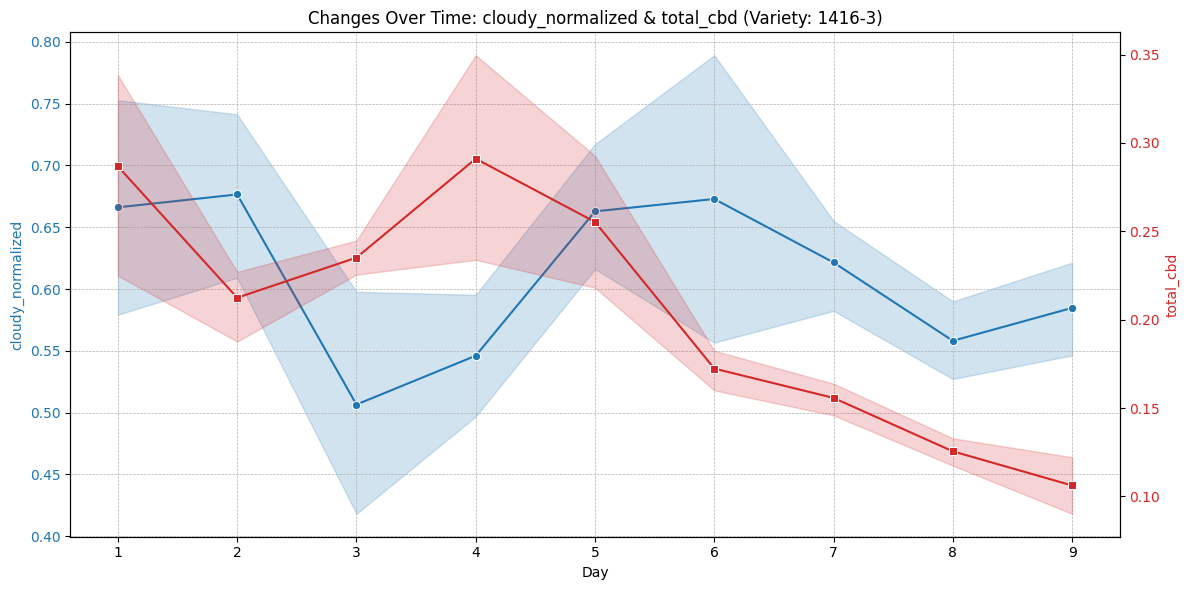

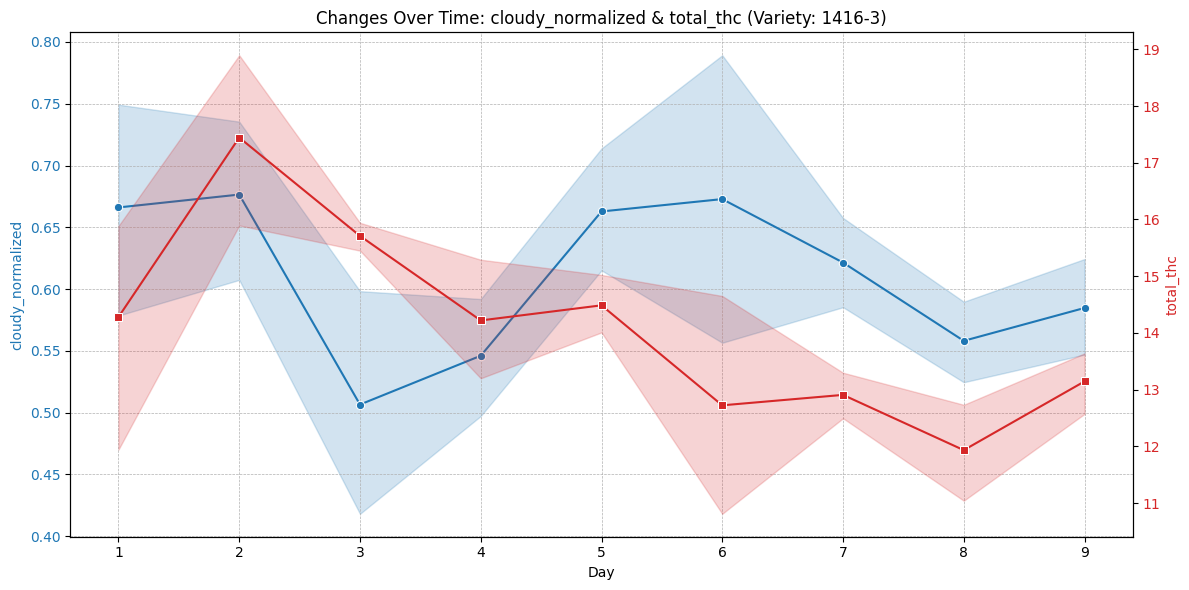

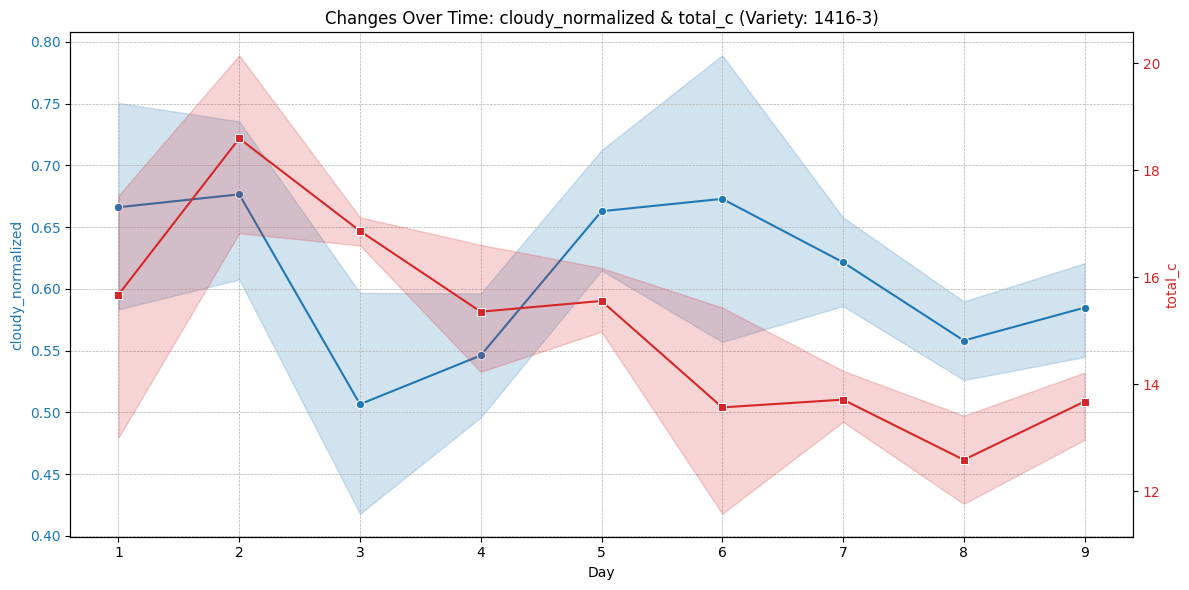

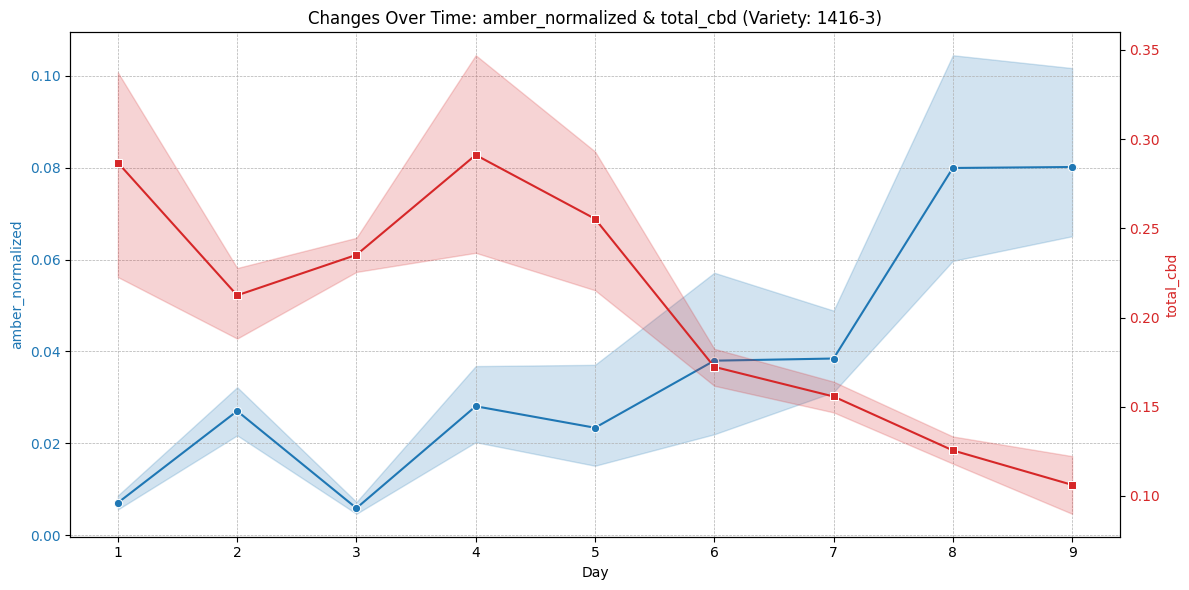

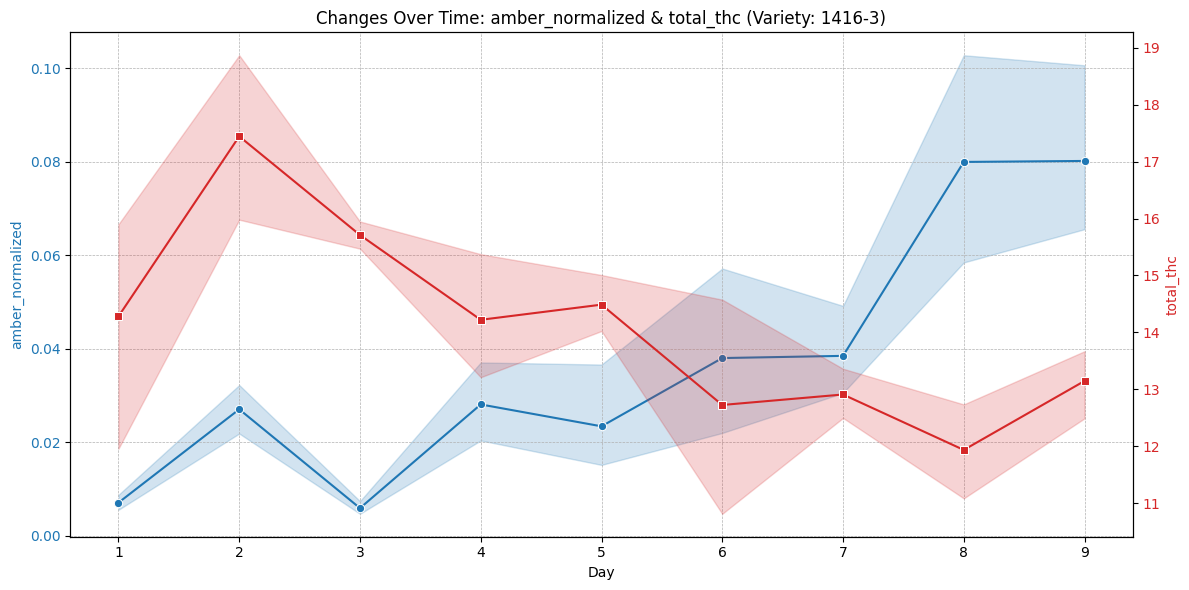

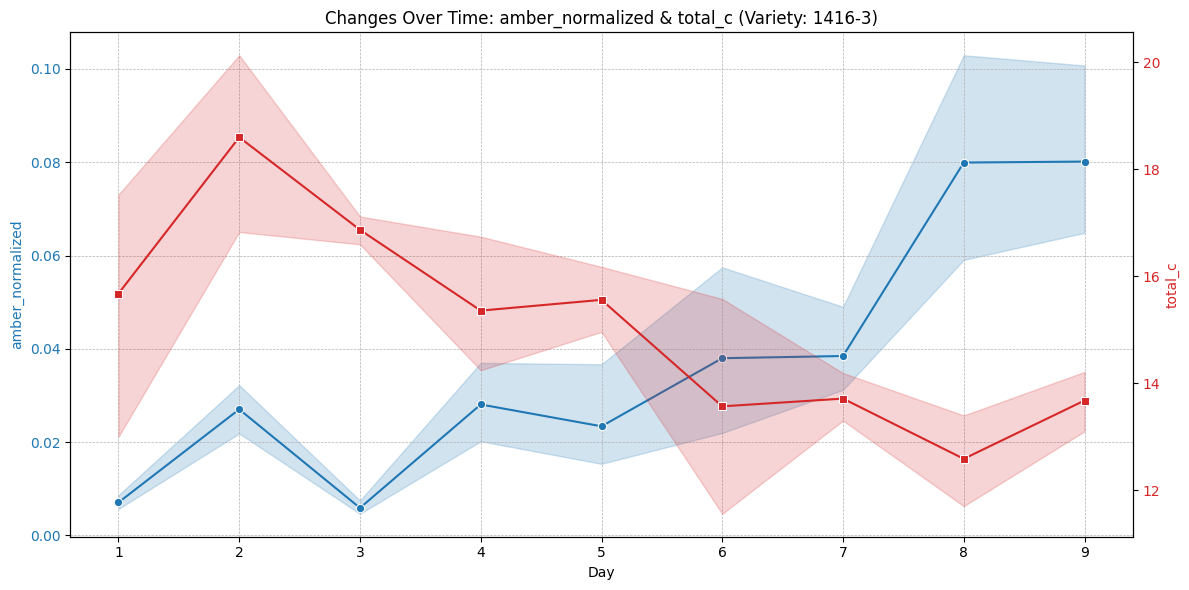

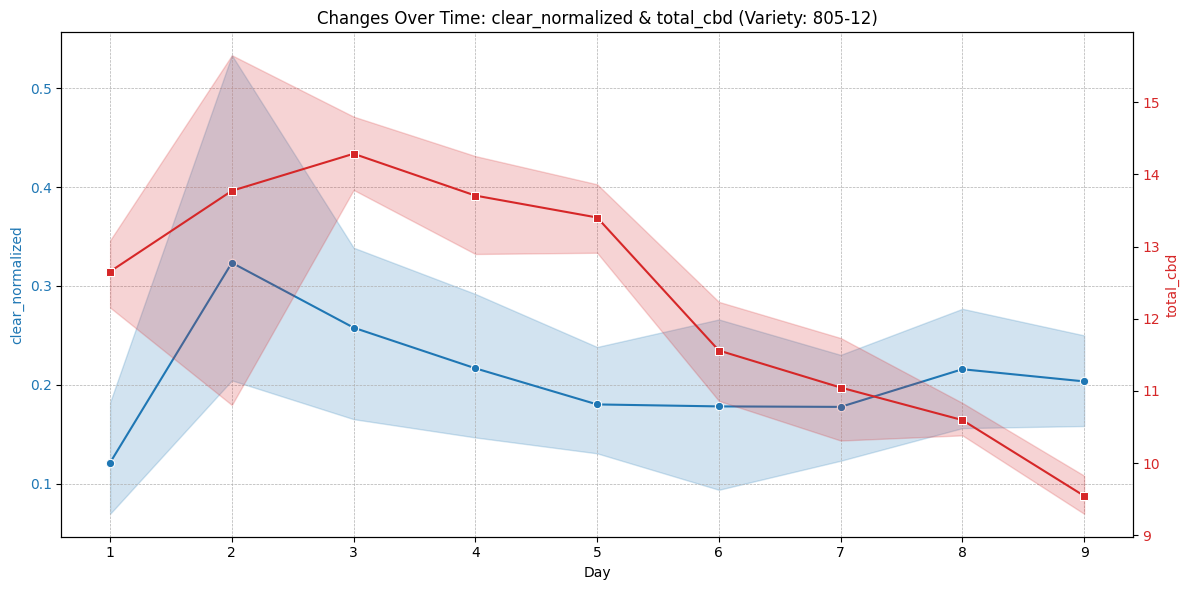

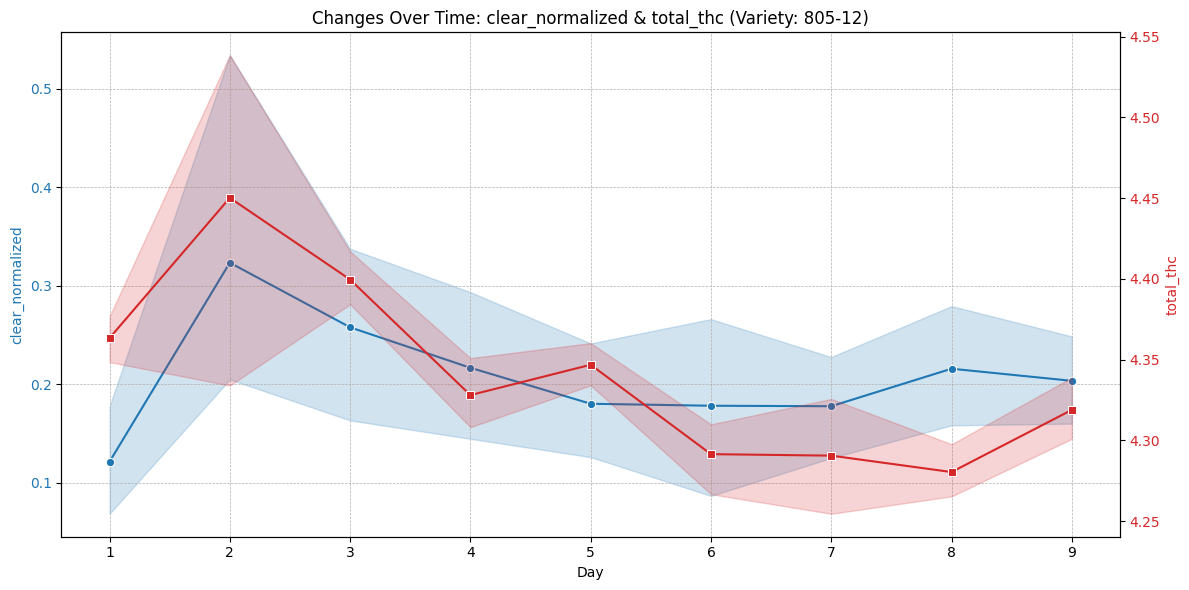

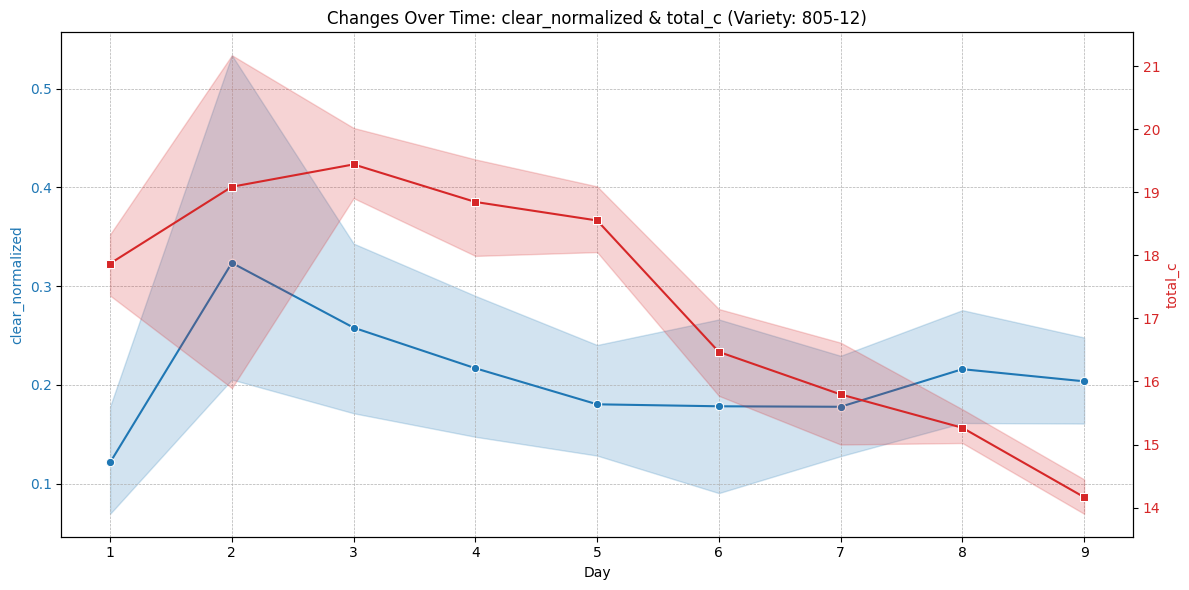

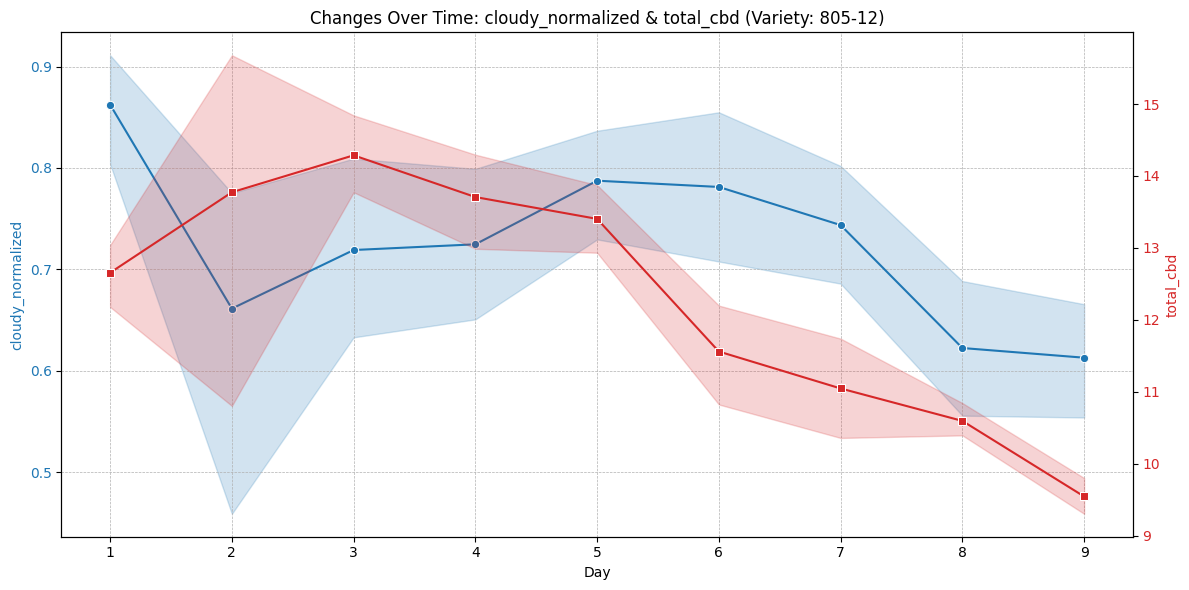

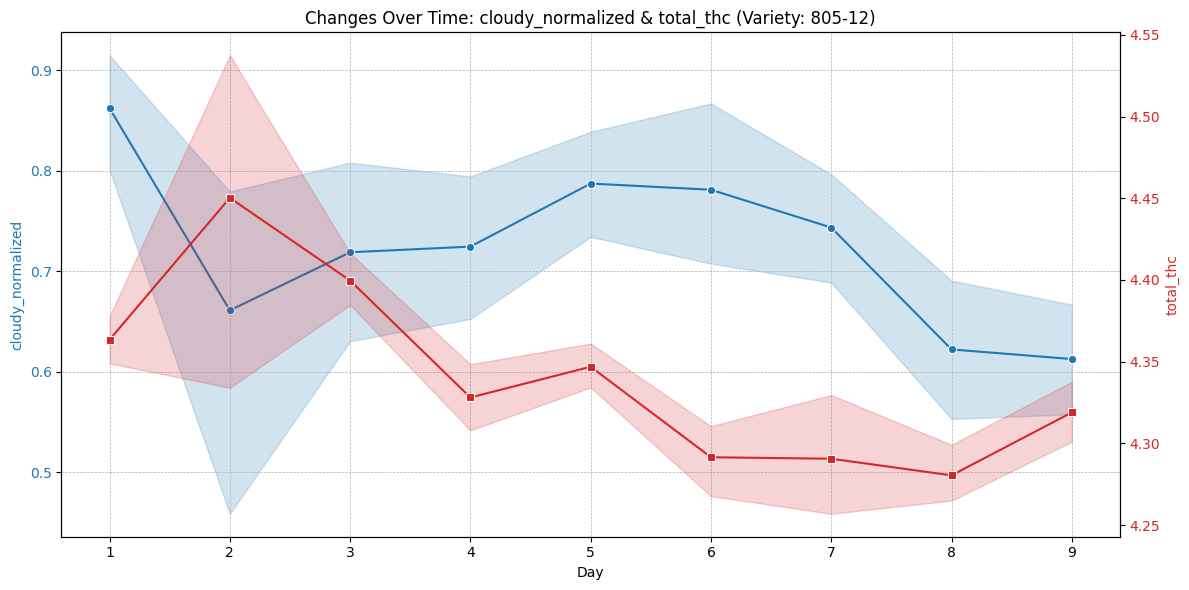

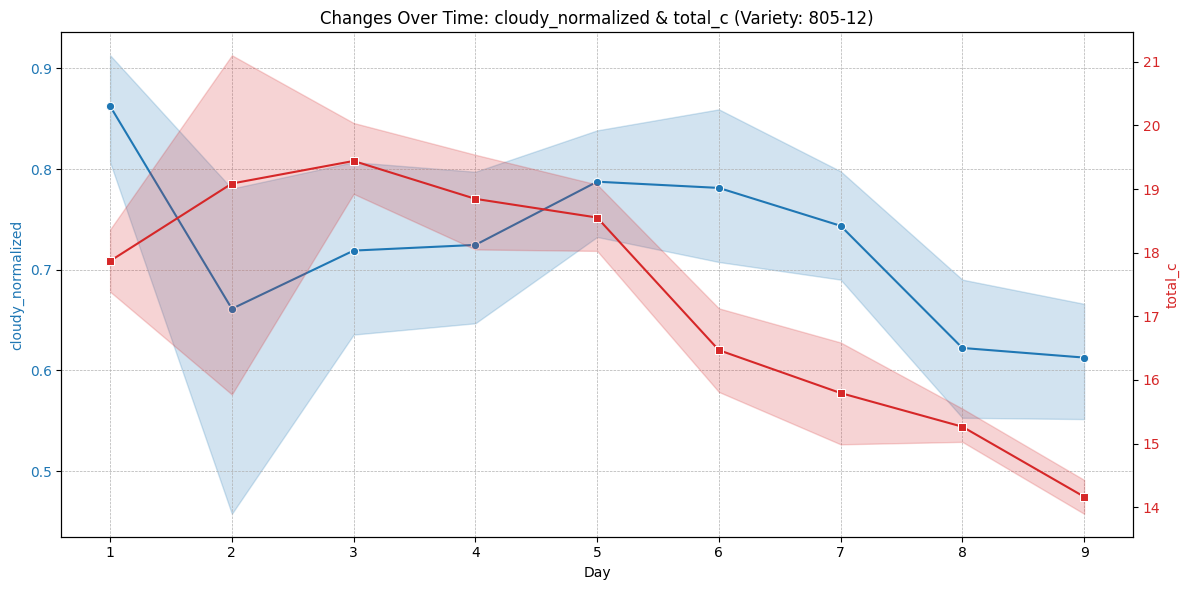

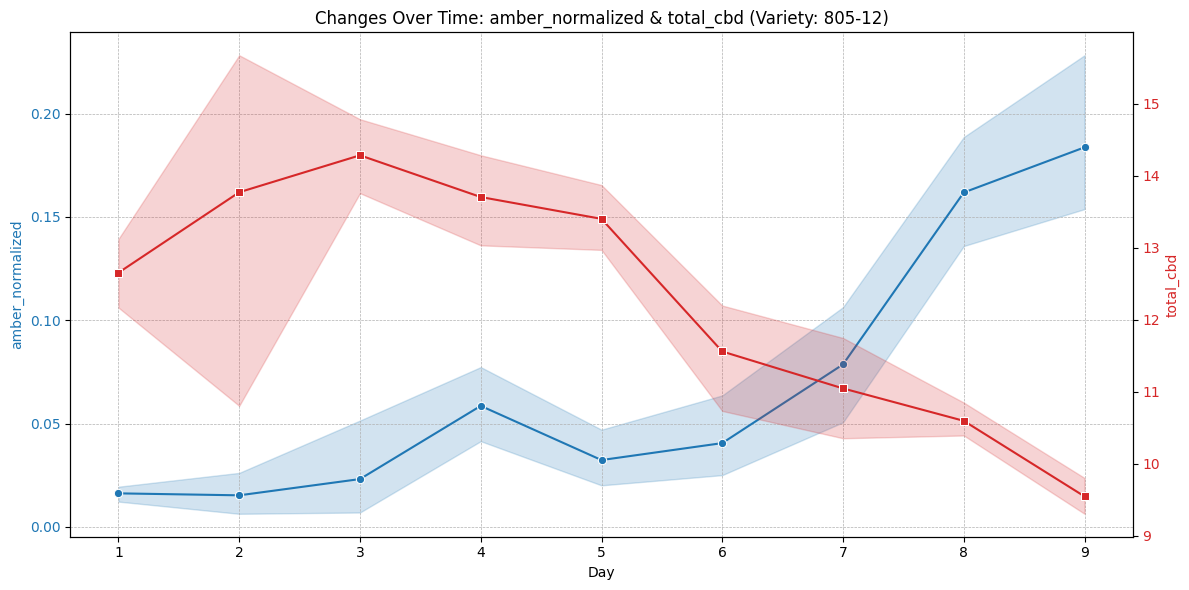

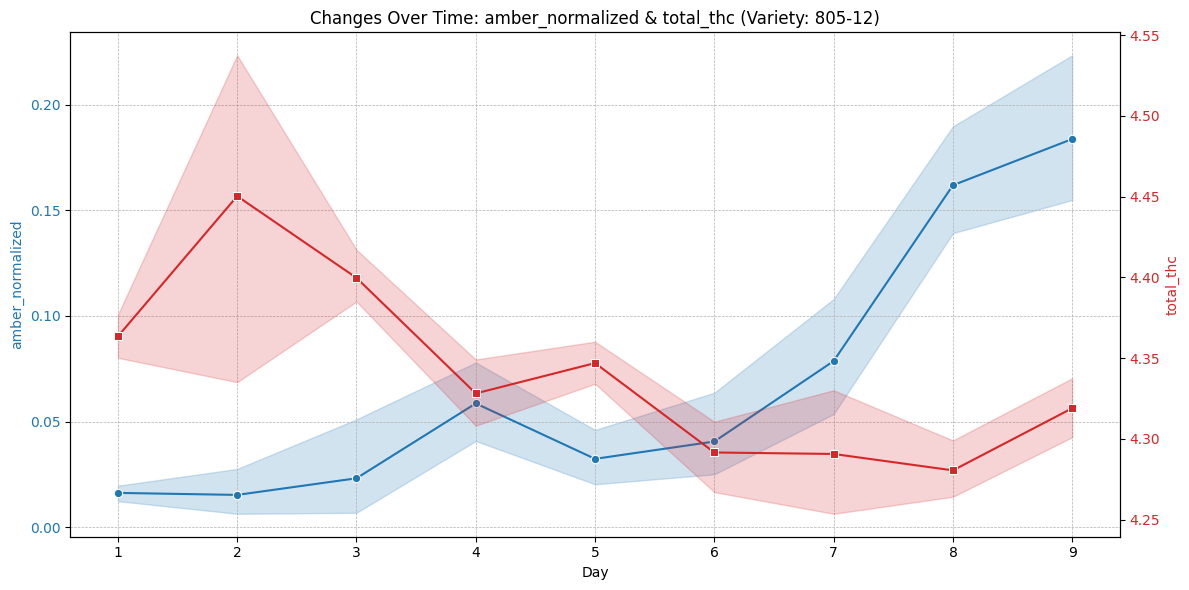

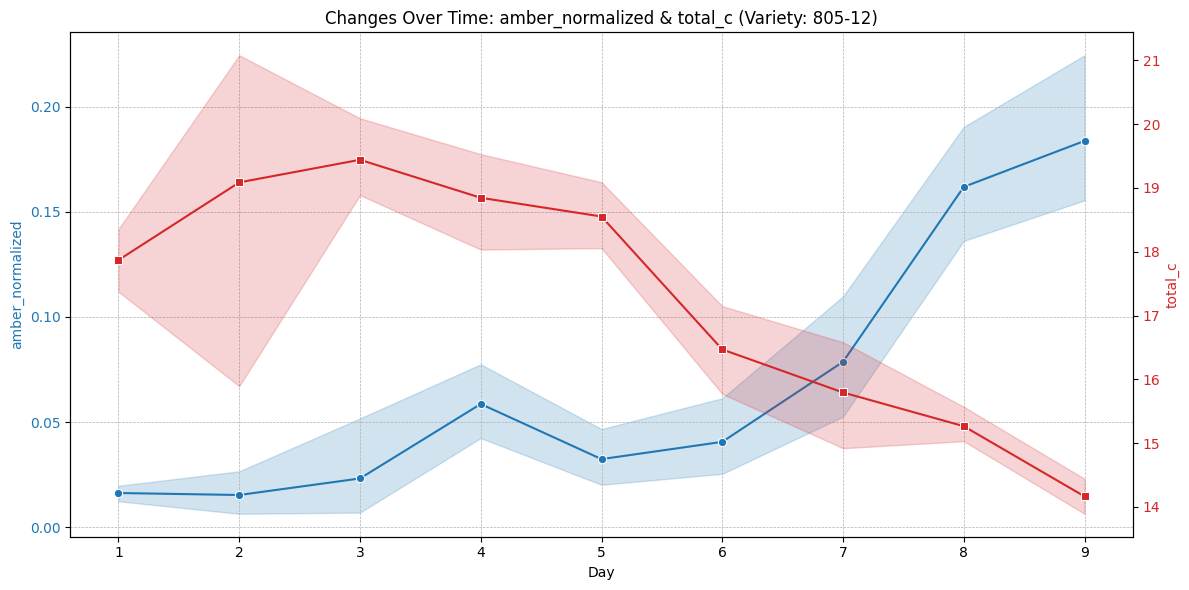

In [10]:
import matplotlib.ticker as ticker

trichome_variables = ["clear_normalized", "cloudy_normalized", "amber_normalized"]
hplc_variables = ["total_cbd", "total_thc", "total_c"]

# Generate plots for each trichome variable paired with each HPLC variable without normalization but on different scales
for variety in merged_df["var"].unique():
    for trichome in trichome_variables:
        for hplc in hplc_variables:
            fig, ax1 = plt.subplots(figsize=(12, 6))

            # Plot trichome variable on left y-axis
            ax1.set_xlabel("Day")
            ax1.set_ylabel(trichome, color="tab:blue")
            sns.lineplot(data=merged_df[merged_df["var"] == variety], x="day", y=trichome, color="tab:blue", marker="o", ax=ax1)
            ax1.tick_params(axis="y", labelcolor="tab:blue")
            ax1.grid(True, linestyle="--", linewidth=0.5)

            # Create secondary y-axis for the HPLC variable
            ax2 = ax1.twinx()
            ax2.set_ylabel(hplc, color="tab:red")
            sns.lineplot(data=merged_df[merged_df["var"] == variety], x="day", y=hplc, color="tab:red", marker="s", ax=ax2)
            ax2.tick_params(axis="y", labelcolor="tab:red")

            # Format x-axis ticks
            ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

            # Title and layout adjustments
            plt.title(f"Changes Over Time: {trichome} & {hplc} (Variety: {variety})")
            fig.tight_layout()
            plt.show()


## Dynamics of Cannabinoid Accumulation
Objective: Investigate how cannabinoid levels (e.g., THC, CBD, CBG) change over time as trichomes transition from clear to cloudy to amber.

### Key Questions:

How do cannabinoid profiles evolve during each stage of trichome maturity?

Is there a critical window where specific cannabinoids peak in concentration?

Potential Insights: This could help optimize harvest timing for specific cannabinoid profiles, such as maximizing CBG by harvesting during the clear trichome stage.

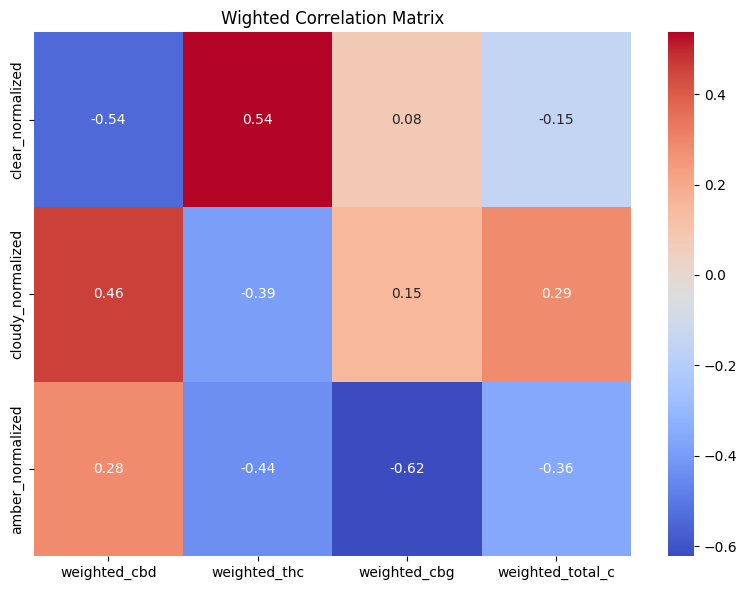

In [46]:
import numpy as np

# Compute weighted averages of cannabinoids based on trichome proportions
merged_df["weighted_cbd"] = merged_df["clear_normalized"] * merged_df["total_cbd"] + merged_df["cloudy_normalized"] * merged_df["total_cbd"] + merged_df["amber_normalized"] * merged_df["total_cbd"]
merged_df["weighted_thc"] = merged_df["clear_normalized"] * merged_df["total_thc"] + merged_df["cloudy_normalized"] * merged_df["total_thc"] + merged_df["amber_normalized"] * merged_df["total_thc"]
merged_df["weighted_cbg"] = merged_df["clear_normalized"] * merged_df["total_cbg"] + merged_df["cloudy_normalized"] * merged_df["total_cbg"] + merged_df["amber_normalized"] * merged_df["total_cbg"]
merged_df["weighted_total_c"] = merged_df["clear_normalized"] * merged_df["total_c"] + merged_df["cloudy_normalized"] * merged_df["total_c"] + merged_df["amber_normalized"] * merged_df["total_c"]

# Compute correlations between trichome proportions and cannabinoid levels
weighted_correlation = merged_df[["clear_normalized", "cloudy_normalized", "amber_normalized", 
                        "weighted_cbd", "weighted_thc", "weighted_cbg", "weighted_total_c"]].corr()

weighted_hplc_cols = ["weighted_cbd", "weighted_thc", "weighted_cbg", "weighted_total_c"]

weighted_correlation = weighted_correlation.loc[trichome_vars, weighted_hplc_cols]

plt.figure(figsize=(8, 6))
sns.heatmap(weighted_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Wighted Correlation Matrix')
plt.tight_layout()
plt.show()

In [51]:
merged_df.columns

Index(['day', 'location', 'flower_id', 'clear_count', 'cloudy_count',
       'amber_count', 'clear_normalized', 'cloudy_normalized',
       'amber_normalized', 'var', 'rep', 'total_cbd', 'total_thc', 'total_cbg',
       'total_c', 'trichome_stage', 'weighted_cbd', 'weighted_thc',
       'weighted_cbg', 'weighted_total_c'],
      dtype='object')

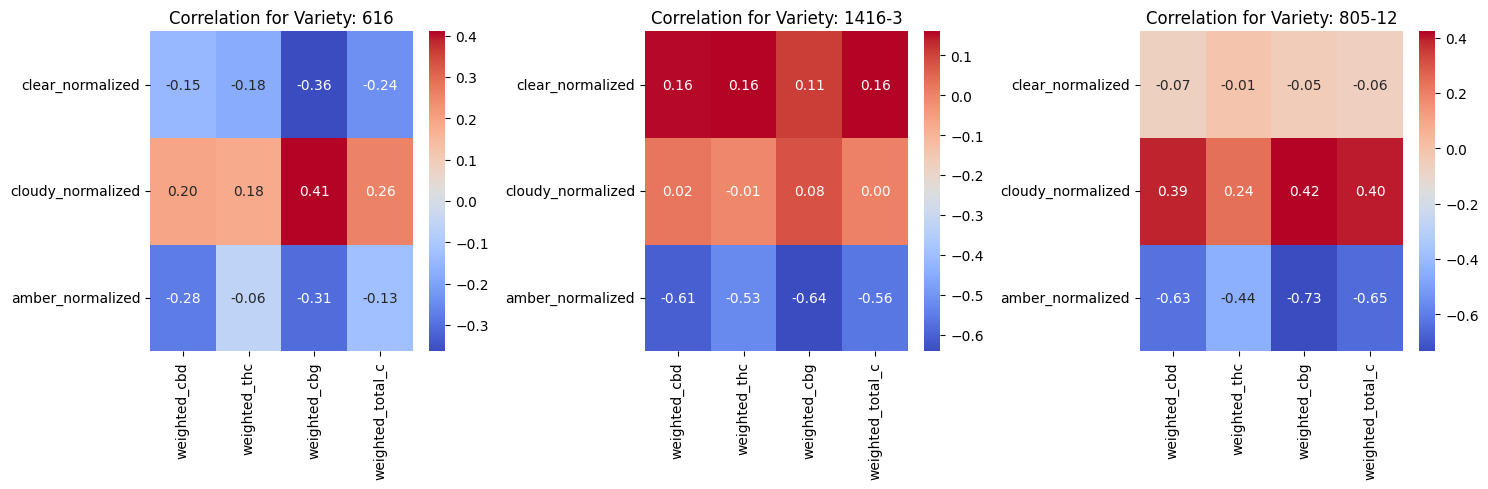

In [52]:
weighted_corr_columns = ["clear_normalized", "cloudy_normalized", "amber_normalized"] + weighted_hplc_cols
plot_variety_heatmaps(merged_df, 'var', weighted_corr_columns, trichome_vars, weighted_hplc_cols)

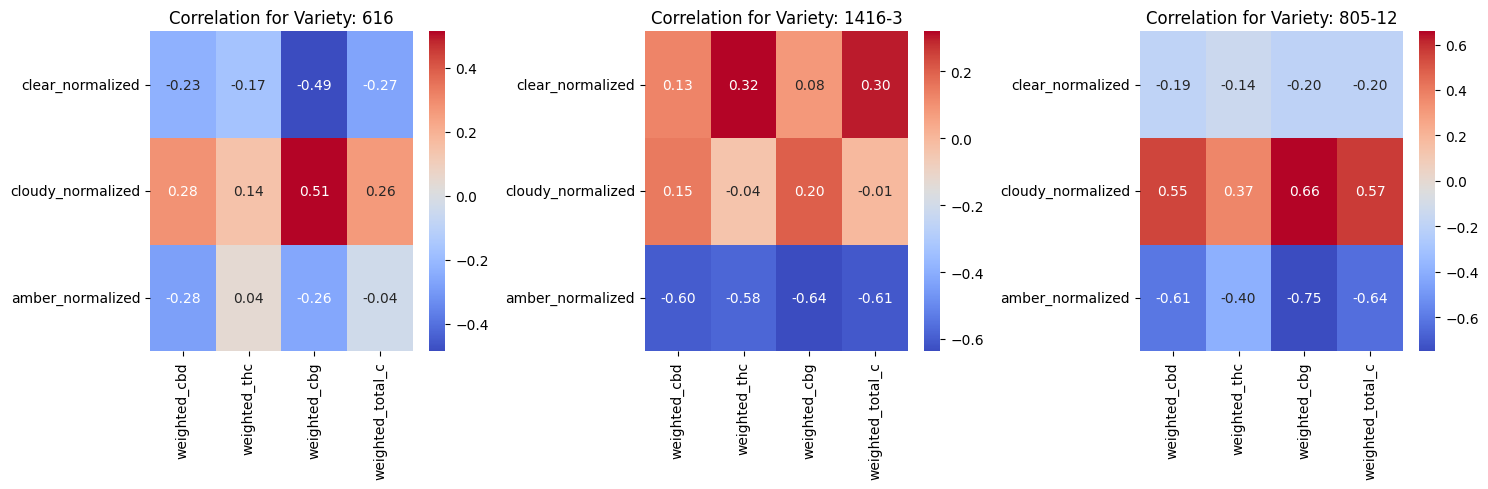

In [53]:
# Compute weighted averages of cannabinoids based on trichome proportions
df_greenhouse["weighted_cbd"] = df_greenhouse["clear_normalized"] * df_greenhouse["total_cbd"] + df_greenhouse["cloudy_normalized"] * df_greenhouse["total_cbd"] + df_greenhouse["amber_normalized"] * df_greenhouse["total_cbd"]
df_greenhouse["weighted_thc"] = df_greenhouse["clear_normalized"] * df_greenhouse["total_thc"] + df_greenhouse["cloudy_normalized"] * df_greenhouse["total_thc"] + df_greenhouse["amber_normalized"] * df_greenhouse["total_thc"]
df_greenhouse["weighted_cbg"] = df_greenhouse["clear_normalized"] * df_greenhouse["total_cbg"] + df_greenhouse["cloudy_normalized"] * df_greenhouse["total_cbg"] + df_greenhouse["amber_normalized"] * df_greenhouse["total_cbg"]
df_greenhouse["weighted_total_c"] = df_greenhouse["clear_normalized"] * df_greenhouse["total_c"] + df_greenhouse["cloudy_normalized"] * df_greenhouse["total_c"] + df_greenhouse["amber_normalized"] * df_greenhouse["total_c"]

plot_variety_heatmaps(df_greenhouse, 'var', weighted_corr_columns, trichome_vars, weighted_hplc_cols)

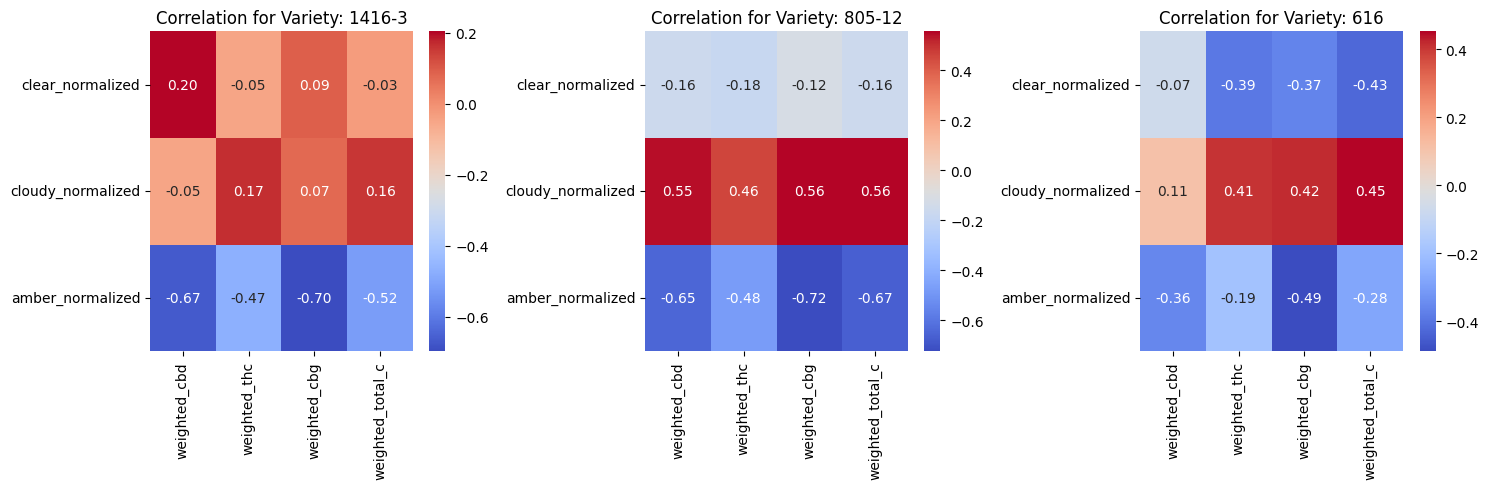

In [54]:
# Compute weighted averages of cannabinoids based on trichome proportions
# Compute weighted averages of cannabinoids based on trichome proportions
df_lab["weighted_cbd"] = df_lab["clear_normalized"] * df_lab["total_cbd"] + df_lab["cloudy_normalized"] * df_lab["total_cbd"] + df_lab["amber_normalized"] * df_lab["total_cbd"]
df_lab["weighted_thc"] = df_lab["clear_normalized"] * df_lab["total_thc"] + df_lab["cloudy_normalized"] * df_lab["total_thc"] + df_lab["amber_normalized"] * df_lab["total_thc"]
df_lab["weighted_cbg"] = df_lab["clear_normalized"] * df_lab["total_cbg"] + df_lab["cloudy_normalized"] * df_lab["total_cbg"] + df_lab["amber_normalized"] * df_lab["total_cbg"]
df_lab["weighted_total_c"] = df_lab["clear_normalized"] * df_lab["total_c"] + df_lab["cloudy_normalized"] * df_lab["total_c"] + df_lab["amber_normalized"] * df_lab["total_c"]

plot_variety_heatmaps(df_lab, 'var', weighted_corr_columns, trichome_vars, weighted_hplc_cols)


In [58]:
import statsmodels.api as sm

def analyze_trichome_cannabinoid_relationship(df, trichome_vars, target_cannabinoid, specific_trichome='amber_normalized'):
    """
    Perform visual and regression analysis of trichome proportions and cannabinoid levels.
    """
    unique_varieties = df["var"].unique()

    for var in unique_varieties:
        subset_df = df[df["var"] == var]
        
        print(f"\n### Analysis for Variety: {var} ###\n")

        # Scatter plot: Specific trichome vs target cannabinoid
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=specific_trichome, y=target_cannabinoid, data=subset_df)
        plt.xlabel(f'Normalized {specific_trichome.capitalize()} Count')
        plt.ylabel(target_cannabinoid.replace("_", " ").title())
        plt.title(f'Relationship between {specific_trichome.capitalize()} Trichomes and {target_cannabinoid} - {var}')
        plt.show()

        # Regression Analysis: Predict target cannabinoid from all trichome proportions
        X = subset_df[trichome_vars]
        y = subset_df[target_cannabinoid]
        
        # Add constant for intercept
        X = sm.add_constant(X)

        # Fit OLS regression model
        model = sm.OLS(y, X).fit()
        print(model.summary())

        # Visualize regression fit for the specific trichome
        sns.lmplot(x=specific_trichome, y=target_cannabinoid, data=subset_df, aspect=1.5, line_kws={'color': 'red'})
        plt.xlabel(f'Normalized {specific_trichome.capitalize()}')
        plt.ylabel(target_cannabinoid.replace("_", " ").title())
        plt.title(f'Linear Fit: {specific_trichome.capitalize()} vs {target_cannabinoid} - {var}')
        plt.show()



### Analysis for Variety: 616 ###



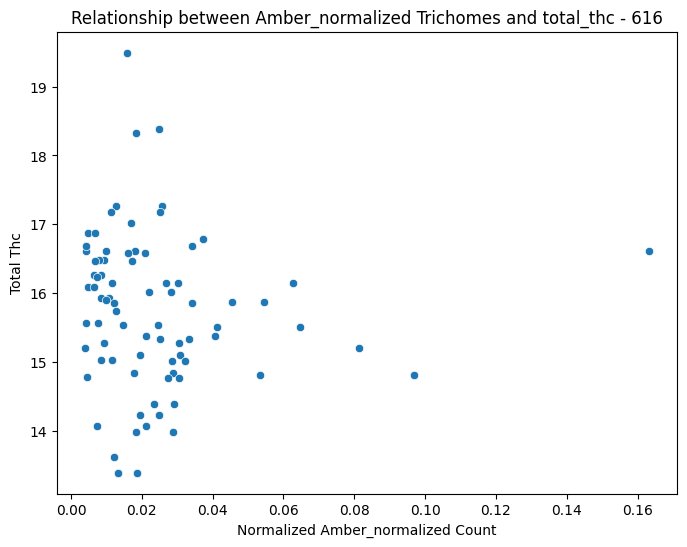

                            OLS Regression Results                            
Dep. Variable:              total_thc   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8917
Date:                Fri, 14 Feb 2025   Prob (F-statistic):              0.449
Time:                        17:50:37   Log-Likelihood:                -120.58
No. Observations:                  80   AIC:                             249.2
Df Residuals:                      76   BIC:                             258.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               399.2201   2675.54

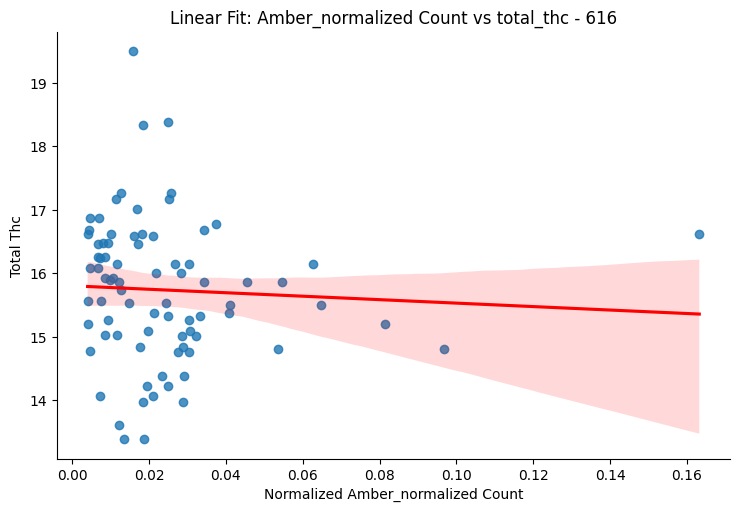


### Analysis for Variety: 1416-3 ###



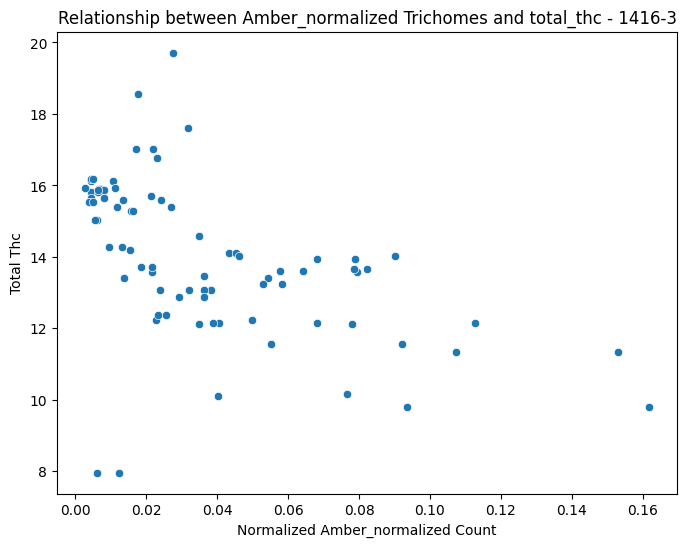

                            OLS Regression Results                            
Dep. Variable:              total_thc   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     9.757
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           1.61e-05
Time:                        17:50:38   Log-Likelihood:                -162.04
No. Observations:                  80   AIC:                             332.1
Df Residuals:                      76   BIC:                             341.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1321.7748   4289.31

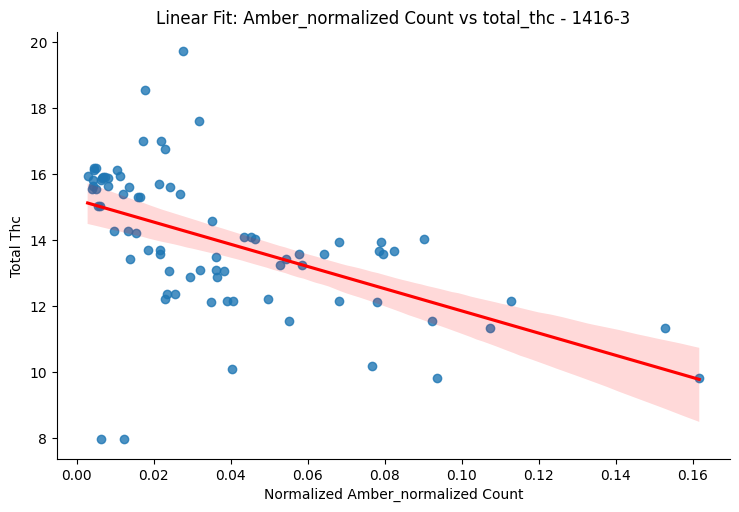


### Analysis for Variety: 805-12 ###



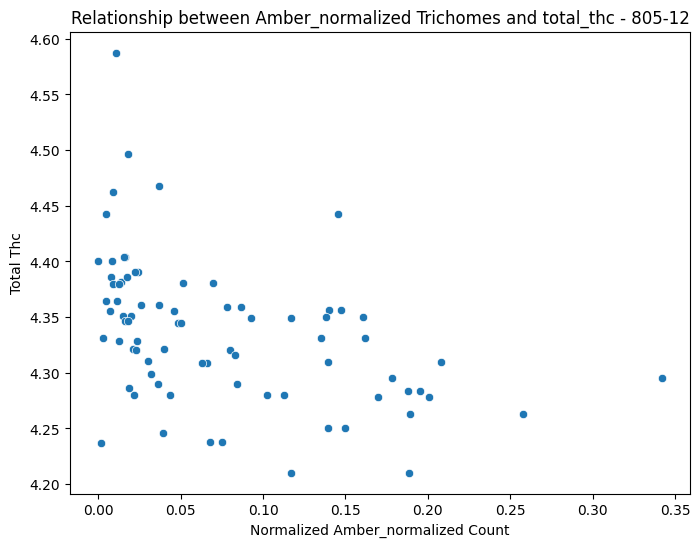

                            OLS Regression Results                            
Dep. Variable:              total_thc   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     6.216
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           0.000791
Time:                        17:50:40   Log-Likelihood:                 113.25
No. Observations:                  79   AIC:                            -218.5
Df Residuals:                      75   BIC:                            -209.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                54.5081    167.01

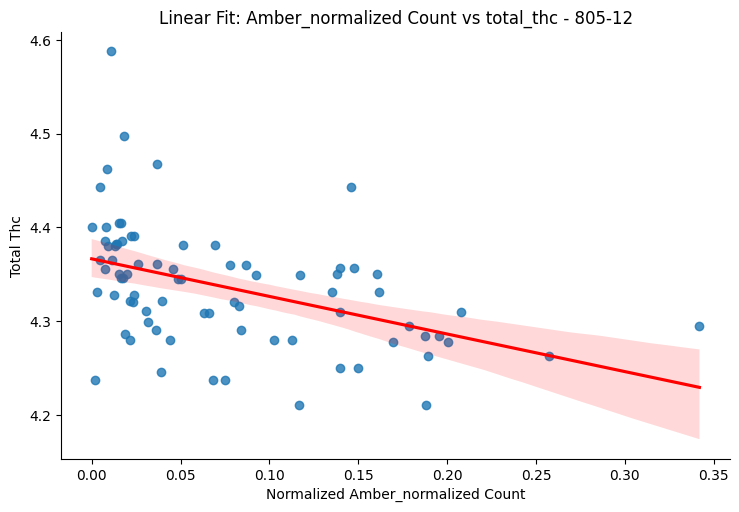


### Analysis for Variety: 616 ###



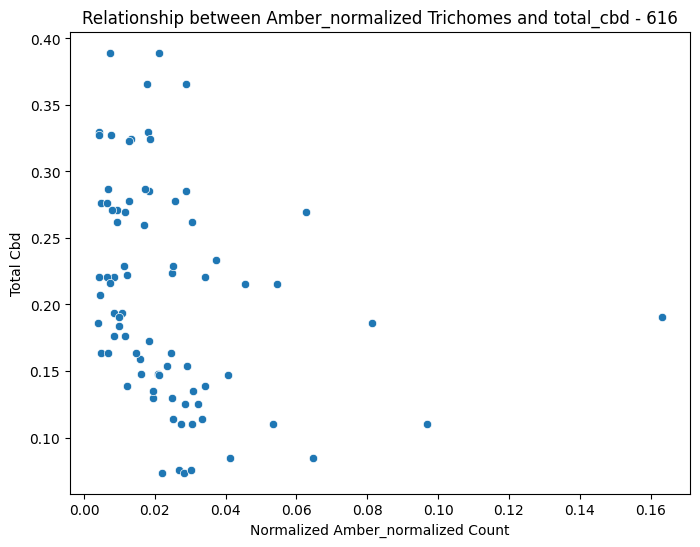

                            OLS Regression Results                            
Dep. Variable:              total_cbd   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2.719
Date:                Fri, 14 Feb 2025   Prob (F-statistic):             0.0504
Time:                        17:50:41   Log-Likelihood:                 91.648
No. Observations:                  80   AIC:                            -175.3
Df Residuals:                      76   BIC:                            -165.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -104.8916    188.49

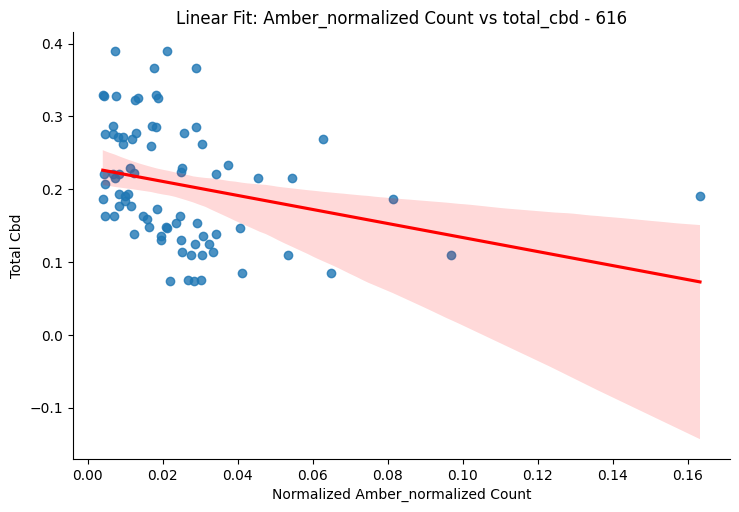


### Analysis for Variety: 1416-3 ###



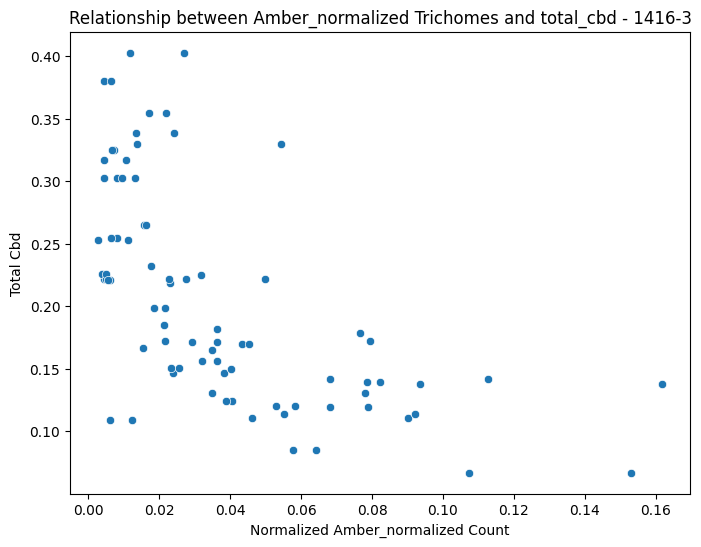

                            OLS Regression Results                            
Dep. Variable:              total_cbd   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     14.90
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           1.01e-07
Time:                        17:50:42   Log-Likelihood:                 101.06
No. Observations:                  80   AIC:                            -194.1
Df Residuals:                      76   BIC:                            -184.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -64.5369    159.98

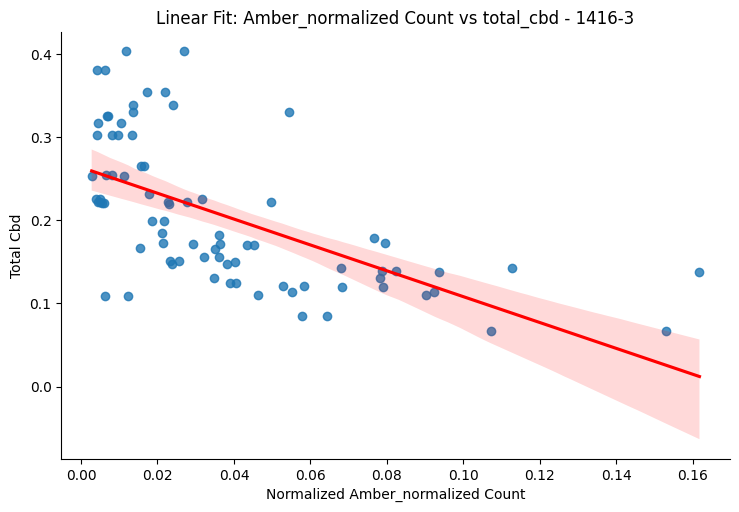


### Analysis for Variety: 805-12 ###



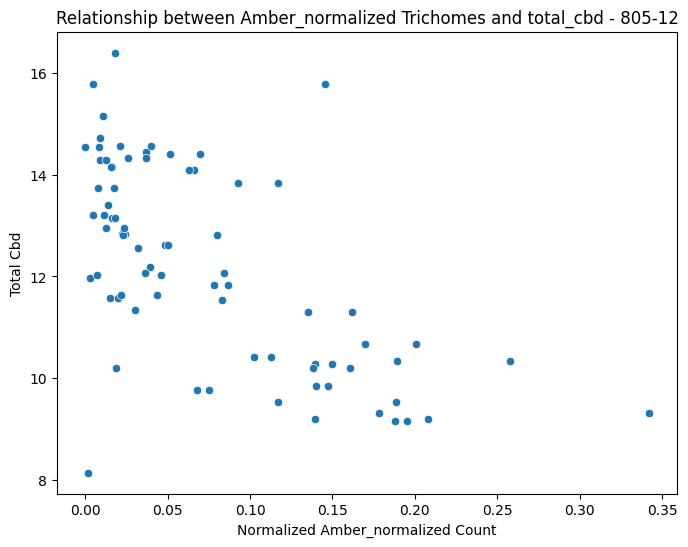

                            OLS Regression Results                            
Dep. Variable:              total_cbd   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     17.86
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           7.60e-09
Time:                        17:50:43   Log-Likelihood:                -143.11
No. Observations:                  79   AIC:                             294.2
Df Residuals:                      75   BIC:                             303.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4336.8061   4286.42

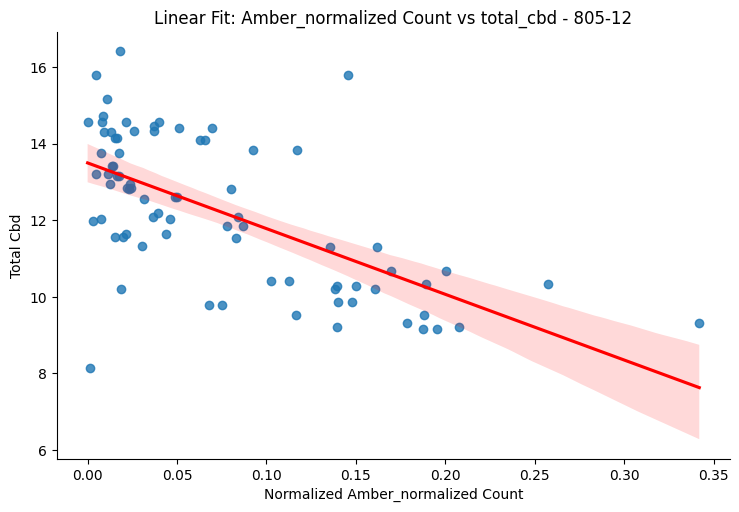


### Analysis for Variety: 616 ###



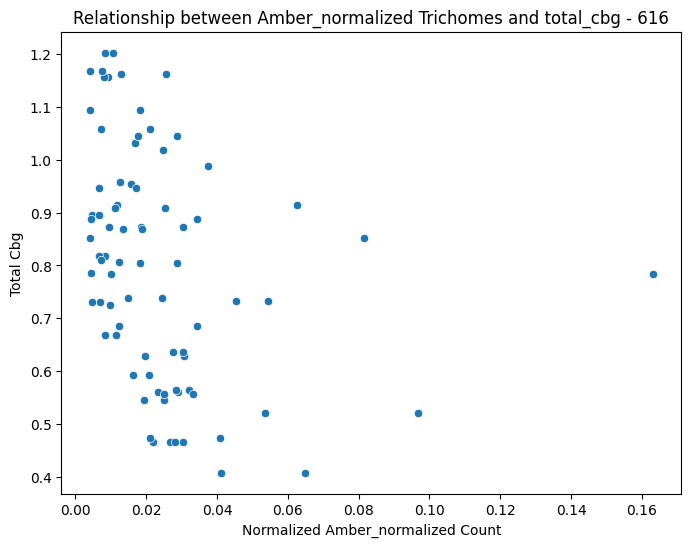

                            OLS Regression Results                            
Dep. Variable:              total_cbg   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     6.876
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           0.000369
Time:                        17:50:45   Log-Likelihood:                 18.258
No. Observations:                  80   AIC:                            -28.52
Df Residuals:                      76   BIC:                            -18.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -152.9475    471.74

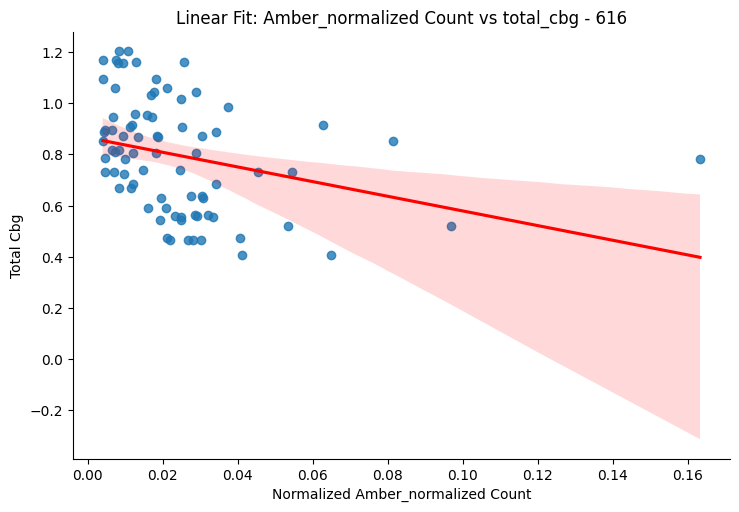


### Analysis for Variety: 1416-3 ###



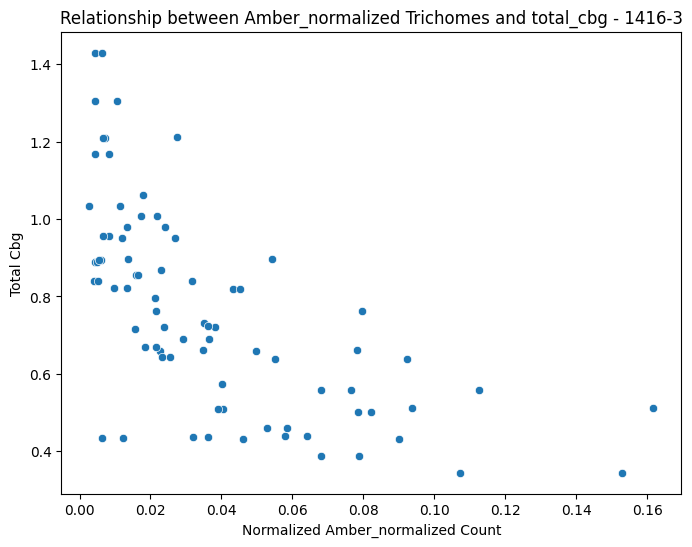

                            OLS Regression Results                            
Dep. Variable:              total_cbg   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     18.17
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           5.49e-09
Time:                        17:50:46   Log-Likelihood:                 14.900
No. Observations:                  80   AIC:                            -21.80
Df Residuals:                      76   BIC:                            -12.27
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -304.7778    469.71

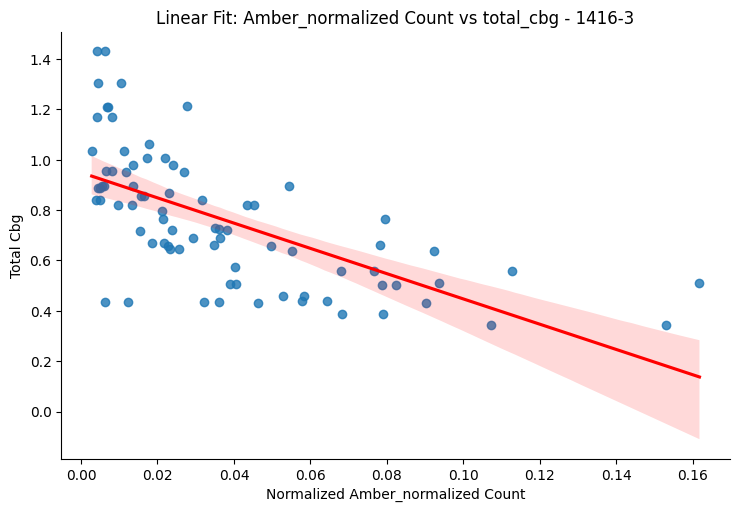


### Analysis for Variety: 805-12 ###



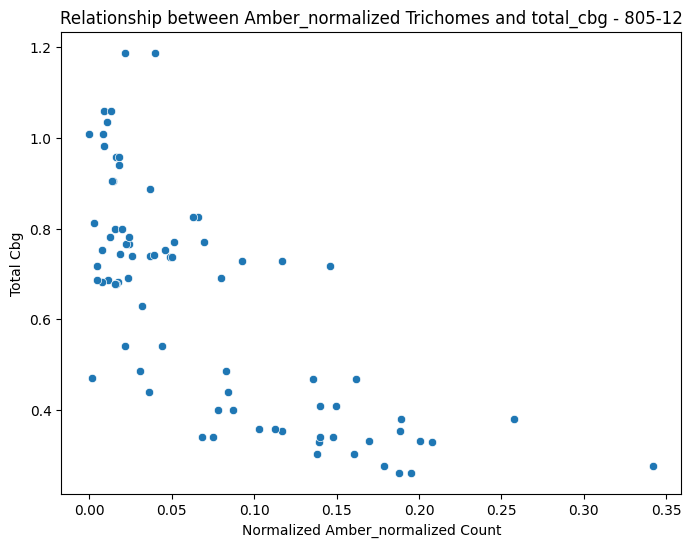

                            OLS Regression Results                            
Dep. Variable:              total_cbg   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     30.58
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           5.09e-13
Time:                        17:50:48   Log-Likelihood:                 30.058
No. Observations:                  79   AIC:                            -52.12
Df Residuals:                      75   BIC:                            -42.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               374.1086    478.76

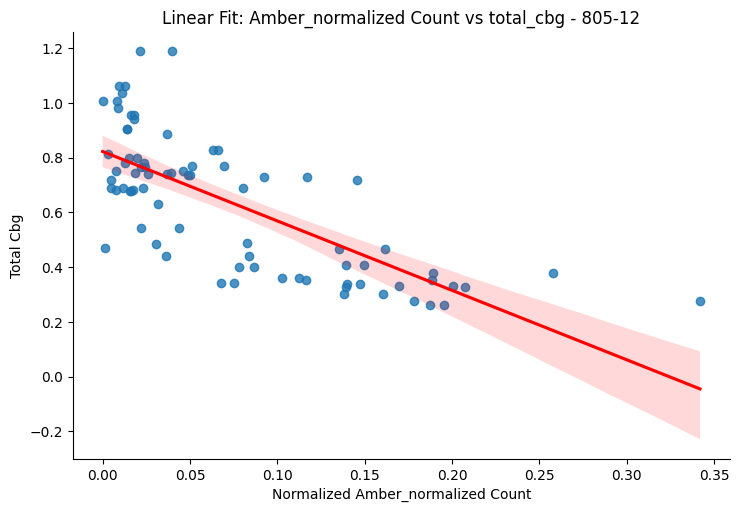

In [59]:
trichome_vars = ["clear_normalized", "cloudy_normalized", "amber_normalized"]

# Run the analysis for total THC
analyze_trichome_cannabinoid_relationship(merged_df, trichome_vars, "total_thc")

# Run the analysis for total CBD
analyze_trichome_cannabinoid_relationship(merged_df, trichome_vars, "total_cbd")

# Run the analysis for total CBG
analyze_trichome_cannabinoid_relationship(merged_df, trichome_vars, "total_cbg")


In [61]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_trichome_cannabinoid_relationship(df, trichome_vars, target_cannabinoid, specific_trichome='amber_normalized'):
    """
    Perform regression analysis of trichome proportions and cannabinoid levels, 
    and visualize all varieties in a single regression plot.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing trichome and cannabinoid data.
    trichome_vars (list): List of trichome proportion columns (e.g., ['clear_normalized', 'cloudy_normalized', 'amber_normalized']).
    target_cannabinoid (str): The target cannabinoid column to predict (e.g., 'total_thc').
    specific_trichome (str): The trichome variable to visualize in scatter plots and regression fit (default: 'amber_normalized').

    Returns:
    None (Displays a single plot and regression summary for each variety)
    """
    unique_varieties = df["var"].unique()

    # Set up a single plot for all varieties
    plt.figure(figsize=(10, 6))
    
    for var in unique_varieties:
        subset_df = df[df["var"] == var]

        # Regression Analysis: Predict target cannabinoid from all trichome proportions
        X = subset_df[trichome_vars]
        y = subset_df[target_cannabinoid]

        # Add constant for intercept
        X = sm.add_constant(X)

        # Fit OLS regression model
        model = sm.OLS(y, X).fit()
        print(f"\n### Regression Summary for Variety: {var} ###")
        print(model.summary())

        # Visualize regression fit for the specific trichome
        sns.regplot(x=specific_trichome, y=target_cannabinoid, data=subset_df, label=f"Variety {var}", scatter_kws={'alpha': 0.5}, line_kws={'lw': 2})

    plt.xlabel(f'Normalized {specific_trichome.capitalize()}')
    plt.ylabel(target_cannabinoid.replace("_", " ").title())
    plt.title(f'Linear Regression: {specific_trichome.capitalize()} vs {target_cannabinoid}')
    plt.legend(title="Cannabis Variety")
    plt.grid(True)
    plt.show()



### Regression Summary for Variety: 616 ###
                            OLS Regression Results                            
Dep. Variable:              total_thc   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8917
Date:                Fri, 14 Feb 2025   Prob (F-statistic):              0.449
Time:                        19:29:08   Log-Likelihood:                -120.58
No. Observations:                  80   AIC:                             249.2
Df Residuals:                      76   BIC:                             258.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

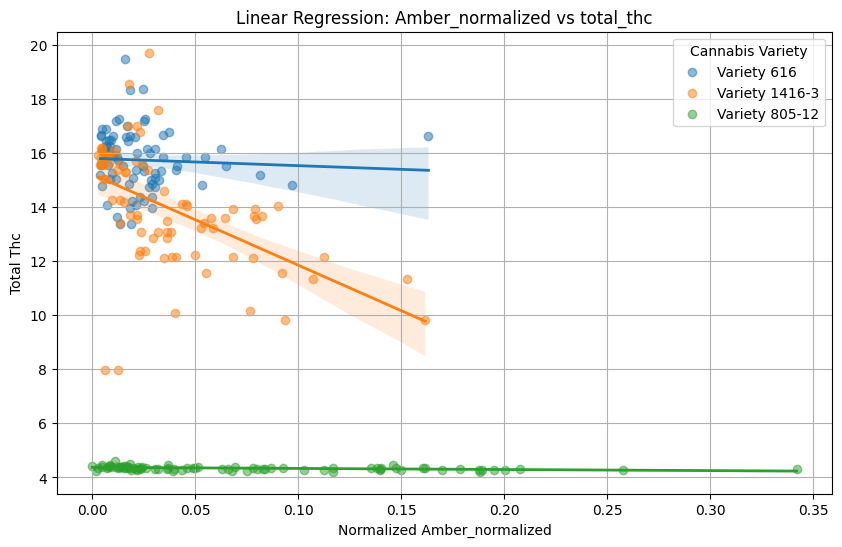


### Regression Summary for Variety: 616 ###
                            OLS Regression Results                            
Dep. Variable:              total_cbd   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2.719
Date:                Fri, 14 Feb 2025   Prob (F-statistic):             0.0504
Time:                        19:29:11   Log-Likelihood:                 91.648
No. Observations:                  80   AIC:                            -175.3
Df Residuals:                      76   BIC:                            -165.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

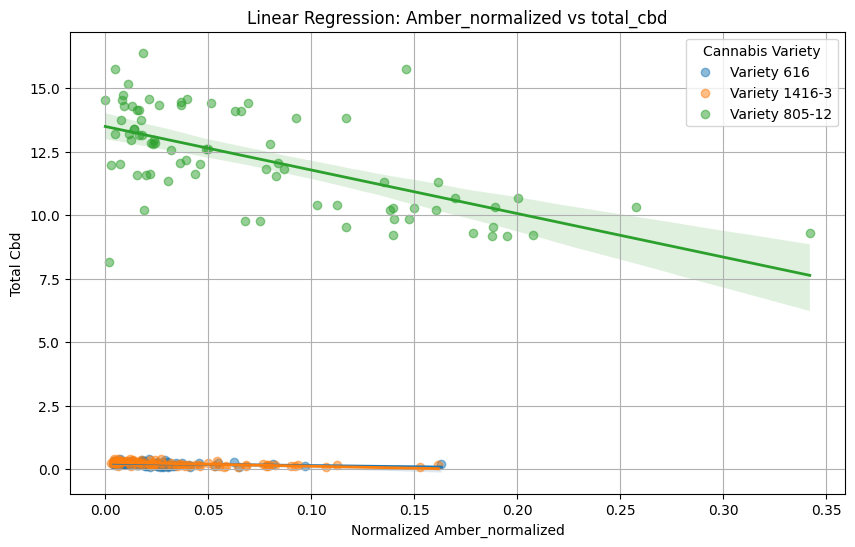


### Regression Summary for Variety: 616 ###
                            OLS Regression Results                            
Dep. Variable:              total_cbg   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     6.876
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           0.000369
Time:                        19:29:12   Log-Likelihood:                 18.258
No. Observations:                  80   AIC:                            -28.52
Df Residuals:                      76   BIC:                            -18.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

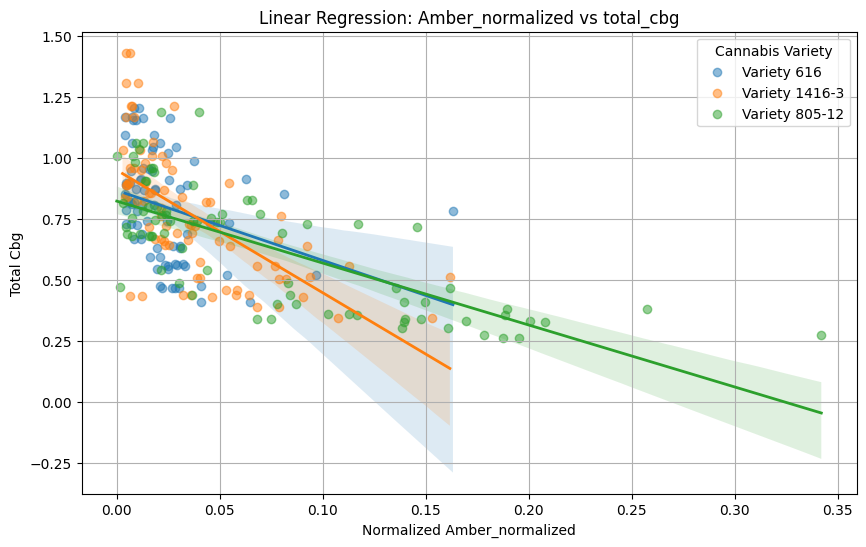

In [62]:
trichome_vars = ["clear_normalized", "cloudy_normalized", "amber_normalized"]

# Run the analysis for total THC
analyze_trichome_cannabinoid_relationship(merged_df, trichome_vars, "total_thc")

# Run the analysis for total CBD
analyze_trichome_cannabinoid_relationship(merged_df, trichome_vars, "total_cbd")

# Run the analysis for total CBG
analyze_trichome_cannabinoid_relationship(merged_df, trichome_vars, "total_cbg")
